[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using device: cuda
Unique tokens in source (en) vocabulary: 13344
Unique tokens in target (fr) vocabulary: 17538

Training model with hyperparameters: {'d_model': 256, 'N': 4, 'h': 8, 'd_ff': 1024, 'dropout': 0.1}
Epoch 1, Batch 100, Loss: 6.3147
Epoch 1, Batch 200, Loss: 5.6320
Epoch 1 completed in 45.23s, Average Loss: 6.6683
Validation Loss: 5.2885
Epoch 2, Batch 100, Loss: 5.1335
Epoch 2, Batch 200, Loss: 5.0288
Epoch 2 completed in 45.17s, Average Loss: 5.1875
Validation Loss: 4.7956
Epoch 3, Batch 100, Loss: 4.8019
Epoch 3, Batch 200, Loss: 4.5198
Epoch 3 completed in 45.17s, Average Loss: 4.7445
Validation Loss: 4.5130
Epoch 4, Batch 100, Loss: 4.5800
Epoch 4, Batch 200, Loss: 4.5060
Epoch 4 completed in 44.93s, Average Loss: 4.4653
Validation Loss: 4.3364
Epoch 5, Batch 100, Loss: 4.3554
Epoch 5, Batch 200, Loss: 4.1834
Epoch 5 completed in 45.04s, Average Loss: 4

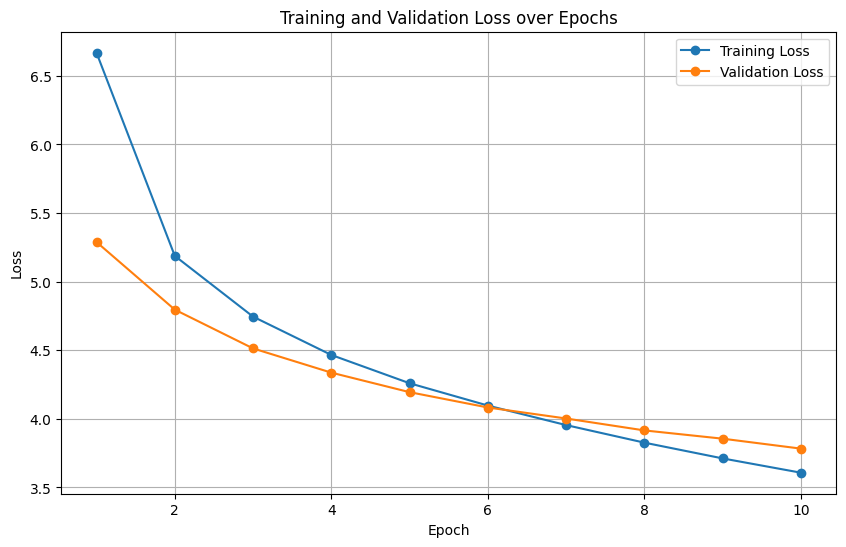

                                          Prediction  BLEU_Score
0  quand je me suis allé à ma mère , j'ai commenc...    0.178918
1     j'étais un moment dans le <UNK> de la guerre .    0.232523
2                    elle était un <UNK> < /talkid >    0.112457
3  maintenant , le premier dans son premier premi...    0.082145
4  quand je suis entendu , je me suis donc <UNK> ...    0.266259


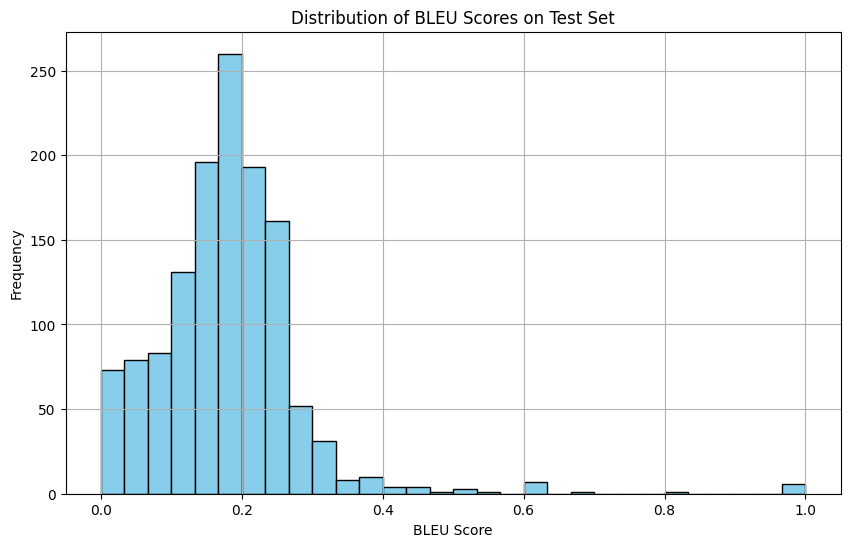

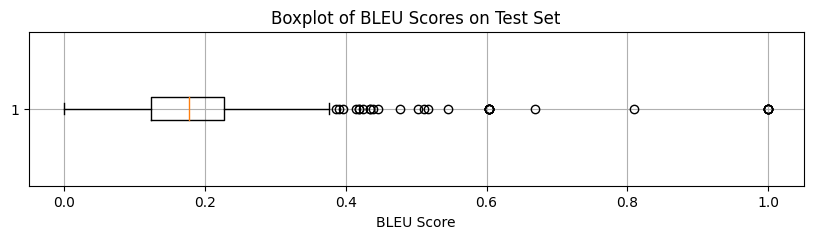

BLEU Score Summary Statistics:
count    1305.000000
mean        0.180546
std         0.105971
min         0.000000
25%         0.124274
50%         0.177544
75%         0.227313
max         1.000000
Name: BLEU_Score, dtype: float64


In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math, copy, time, os
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import numpy as np
import random
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk
import matplotlib.pyplot as plt
import pandas as pd

# Install NLTK data
nltk.download('punkt')

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 1. Data Preparation
class Vocabulary:
    def __init__(self, freq_threshold=2):
        self.freq_threshold = freq_threshold
        self.word2idx = {"<PAD>":0, "<SOS>":1, "<EOS>":2, "<UNK>":3}
        self.idx2word = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"}
        self.word_freq = defaultdict(int)
    
    def build_vocabulary(self, sentence_list):
        for sentence in sentence_list:
            for word in nltk.word_tokenize(sentence.lower()):
                self.word_freq[word] +=1
        for word, freq in self.word_freq.items():
            if freq >= self.freq_threshold:
                self.word2idx[word] = len(self.word2idx)
                self.idx2word[len(self.idx2word)] = word
    
    def numericalize(self, text):
        tokenized = nltk.word_tokenize(text.lower())
        return [self.word2idx.get(token, self.word2idx["<UNK>"]) for token in tokenized]

class TranslationDataset(Dataset):
    def __init__(self, src_file, trg_file, src_vocab, trg_vocab, max_len=50):
        self.src_sentences = []
        self.trg_sentences = []
        with open(src_file, 'r', encoding='utf-8') as f:
            self.src_sentences = f.readlines()
        with open(trg_file, 'r', encoding='utf-8') as f:
            self.trg_sentences = f.readlines()
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab
        self.max_len = max_len
    
    def __len__(self):
        return len(self.src_sentences)
    
    def __getitem__(self, idx):
        src = self.src_sentences[idx].strip()
        trg = self.trg_sentences[idx].strip()
        src_num = [self.src_vocab.word2idx["<SOS>"]]
        src_num += self.src_vocab.numericalize(src)
        src_num.append(self.src_vocab.word2idx["<EOS>"])
        
        trg_num = [self.trg_vocab.word2idx["<SOS>"]]
        trg_num += self.trg_vocab.numericalize(trg)
        trg_num.append(self.trg_vocab.word2idx["<EOS>"])
        
        src_len = len(src_num)
        trg_len = len(trg_num)
        
        if src_len < self.max_len:
            src_num += [self.src_vocab.word2idx["<PAD>"]] * (self.max_len - src_len)
        else:
            src_num = src_num[:self.max_len]
        
        if trg_len < self.max_len:
            trg_num += [self.trg_vocab.word2idx["<PAD>"]] * (self.max_len - trg_len)
        else:
            trg_num = trg_num[:self.max_len]
        
        return torch.tensor(src_num), torch.tensor(trg_num)

# Paths to data
train_src_path = '/kaggle/input/datafiles/data/train.en'
train_trg_path = '/kaggle/input/datafiles/data/train.fr'
dev_src_path = '/kaggle/input/datafiles/data/dev.en'
dev_trg_path = '/kaggle/input/datafiles/data/dev.fr'
test_src_path = '/kaggle/input/datafiles/data/test.en'
test_trg_path = '/kaggle/input/datafiles/data/test.fr'

# Build Vocabularies
with open(train_src_path, 'r', encoding='utf-8') as f:
    train_src = f.readlines()
with open(train_trg_path, 'r', encoding='utf-8') as f:
    train_trg = f.readlines()

SRC_vocab = Vocabulary()
SRC_vocab.build_vocabulary(train_src)

TRG_vocab = Vocabulary()
TRG_vocab.build_vocabulary(train_trg)

print(f"Unique tokens in source (en) vocabulary: {len(SRC_vocab.word2idx)}")
print(f"Unique tokens in target (fr) vocabulary: {len(TRG_vocab.word2idx)}")

# Create Datasets
train_dataset = TranslationDataset(train_src_path, train_trg_path, SRC_vocab, TRG_vocab)
dev_dataset = TranslationDataset(dev_src_path, dev_trg_path, SRC_vocab, TRG_vocab)
test_dataset = TranslationDataset(test_src_path, test_trg_path, SRC_vocab, TRG_vocab)

# Create DataLoaders
BATCH_SIZE = 128

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 2. Model Architecture
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding,self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0,max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0,d_model,2).float() * (-math.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(position * div_term)
        pe[:,1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe',pe)
    
    def forward(self,x):
        x = x + self.pe[:,:x.size(1),:].to(x.device)
        return x

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention,self).__init__()
        assert d_model % h ==0, "d_model must be divisible by h"
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model,d_model),4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            if mask.dim() == 3:
                # self-attn: [batch_size, trg_seq_len, trg_seq_len]
                mask = mask.unsqueeze(1)  # [batch_size,1, trg_seq_len, trg_seq_len]
                mask = mask.expand(-1, self.h, -1, -1)  # [batch_size, h, trg_seq_len, trg_seq_len]
            elif mask.dim() == 2:
                # src-attn: [batch_size, src_seq_len]
                mask = mask.unsqueeze(1).unsqueeze(2)  # [batch_size,1,1, src_seq_len]
                mask = mask.expand(-1, self.h, -1, -1)  # [batch_size, h,1, src_seq_len]
        nbatches = query.size(0)
        
        # 1. Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [l(x).view(nbatches,-1,self.h,self.d_k).transpose(1,2)
                             for l, x in zip(self.linears, (query,key,value))]
        
        # 2. Apply attention on all the projected vectors in batch.
        scores = torch.matmul(query, key.transpose(-2,-1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        p_attn = F.softmax(scores, dim=-1)
        p_attn = self.dropout(p_attn)
        
        # 3. "Concat" using a view and apply a final linear.
        x = torch.matmul(p_attn, value).transpose(1,2).contiguous().view(nbatches,-1,self.h * self.d_k)
        return self.linears[-1](x)

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward,self).__init__()
        self.w_1 = nn.Linear(d_model,d_ff)
        self.w_2 = nn.Linear(d_ff,d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self,x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer,self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.norm1 = nn.LayerNorm(size)
        self.norm2 = nn.LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask):
        # Self-attention sublayer
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        # Feed-forward sublayer
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer,self).__init__()
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.norm1 = nn.LayerNorm(size)
        self.norm2 = nn.LayerNorm(size)
        self.norm3 = nn.LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, memory, src_mask, tgt_mask):
        # Self-attention sublayer
        self_attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(self_attn_output))
        # Source-attention sublayer
        src_attn_output = self.src_attn(x, memory, memory, src_mask)
        x = self.norm2(x + self.dropout(src_attn_output))
        # Feed-forward sublayer
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder,self).__init__()
        self.layers = clones(layer, N)
        self.norm = nn.LayerNorm(layer.self_attn.linears[0].in_features)
    
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder,self).__init__()
        self.layers = clones(layer, N)
        self.norm = nn.LayerNorm(layer.self_attn.linears[0].in_features)
    
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model=256, N=4, h=8, d_ff=1024, dropout=0.1):
        super(Transformer,self).__init__()
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab
        self.d_model = d_model
        
        self.src_embed = nn.Sequential(
            nn.Embedding(len(src_vocab.word2idx), d_model),
            PositionalEncoding(d_model)
        )
        self.trg_embed = nn.Sequential(
            nn.Embedding(len(trg_vocab.word2idx), d_model),
            PositionalEncoding(d_model)
        )
        
        attn = MultiHeadedAttention(h, d_model, dropout)
        ff = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.encoder = Encoder(EncoderLayer(d_model, copy.deepcopy(attn), copy.deepcopy(ff), dropout), N)
        self.decoder = Decoder(DecoderLayer(d_model, copy.deepcopy(attn), copy.deepcopy(attn), copy.deepcopy(ff), dropout), N)
        self.out = nn.Linear(d_model, len(trg_vocab.word2idx))
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, trg, memory, src_mask, trg_mask):
        return self.decoder(self.trg_embed(trg), memory, src_mask, trg_mask)
    
    def forward(self, src, trg, src_mask, trg_mask):
        memory = self.encode(src, src_mask)
        output = self.decode(trg, memory, src_mask, trg_mask)
        return self.out(output)

def make_std_mask(tgt, pad):
    # tgt: [batch_size, trg_seq_len]
    tgt_mask = (tgt != pad).unsqueeze(-2)  # [batch_size,1, trg_seq_len]
    trg_len = tgt.size(1)
    tgt_mask = tgt_mask & subsequent_mask(trg_len).to(tgt.device)  # [batch_size, trg_seq_len, trg_seq_len]
    return tgt_mask

def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(torch.uint8)
    return subsequent_mask == 0

# 3. Training

def train_model(model, train_loader, dev_loader, optimizer, criterion, epochs, trg_pad_idx):
    model.train()
    train_losses = []
    val_losses = []
    
    for epoch in range(1, epochs+1):
        start_time = time.time()
        total_loss = 0
        for i, (src, trg) in enumerate(train_loader):
            src = src.to(device)
            trg = trg.to(device)
            optimizer.zero_grad()
            src_mask = (src != SRC_vocab.word2idx["<PAD>"]).to(device)  # [batch_size, src_seq_len]
            trg_input = trg[:, :-1]  # [batch_size, trg_seq_len -1]
            trg_output = trg[:,1:]   # [batch_size, trg_seq_len -1]
            trg_mask = make_std_mask(trg_input, trg_pad_idx)  # [batch_size, trg_seq_len -1, trg_seq_len -1]
            output = model(src, trg_input, src_mask, trg_mask)  # [batch_size, trg_seq_len -1, trg_vocab_size]
            output = output.view(-1, output.size(-1))  # [batch_size * (trg_seq_len -1), trg_vocab_size]
            trg_output = trg_output.contiguous().view(-1)  # [batch_size * (trg_seq_len -1)]
            loss = criterion(output, trg_output)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            total_loss += loss.item()
            if (i+1) % 100 ==0:
                print(f"Epoch {epoch}, Batch {i+1}, Loss: {loss.item():.4f}")
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch} completed in {time.time()-start_time:.2f}s, Average Loss: {avg_loss:.4f}")
        val_loss = evaluate(model, dev_loader, criterion, trg_pad_idx)
        val_losses.append(val_loss)
    torch.save(model.state_dict(), 'transformer.pt')
    print("Training complete and model saved as transformer.pt")
    return train_losses, val_losses

def evaluate(model, dev_loader, criterion, trg_pad_idx):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, trg in dev_loader:
            src = src.to(device)
            trg = trg.to(device)
            src_mask = (src != SRC_vocab.word2idx["<PAD>"]).to(device)  # [1, src_seq_len]
            trg_input = trg[:, :-1]  # [1, trg_seq_len -1]
            trg_output = trg[:,1:]   # [1, trg_seq_len -1]
            trg_mask = make_std_mask(trg_input, trg_pad_idx)  # [1, trg_seq_len -1, trg_seq_len -1]
            output = model(src, trg_input, src_mask, trg_mask)  # [1, trg_seq_len -1, trg_vocab_size]
            output = output.view(-1, output.size(-1))  # [1 * (trg_seq_len -1), trg_vocab_size]
            trg_output = trg_output.contiguous().view(-1)  # [1 * (trg_seq_len -1)]
            loss = criterion(output, trg_output)
            total_loss += loss.item()
    avg_loss = total_loss / len(dev_loader)
    print(f"Validation Loss: {avg_loss:.4f}")
    model.train()
    return avg_loss

# 4. Initialize and Train the Model (Without Hyperparameter Tuning)

# Define hyperparameters
hyperparams = {
    'd_model': 256,
    'N': 4,
    'h': 8,
    'd_ff': 1024,
    'dropout': 0.1
}

print(f"\nTraining model with hyperparameters: {hyperparams}")

# Initialize the model
model = Transformer(SRC_vocab, TRG_vocab, 
                    d_model=hyperparams['d_model'], 
                    N=hyperparams['N'],
                    h=hyperparams['h'], 
                    d_ff=hyperparams['d_ff'], 
                    dropout=hyperparams['dropout']).to(device)

# Initialize optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index=TRG_vocab.word2idx["<PAD>"])

# Train the model and capture loss history
train_losses, val_losses = train_model(model, train_loader, dev_loader, optimizer, criterion, epochs=10, trg_pad_idx=TRG_vocab.word2idx["<PAD>"])

# 5. Testing and BLEU Score Calculation

def translate_sentence(model, sentence, src_vocab, trg_vocab, max_len=50):
    model.eval()
    tokens = ["<SOS>"] + nltk.word_tokenize(sentence.lower()) + ["<EOS>"]
    src_indexes = [src_vocab.word2idx.get(word, src_vocab.word2idx["<UNK>"]) for word in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)  # [1, src_seq_len]
    src_mask = (src_tensor != src_vocab.word2idx["<PAD>"]).to(device)  # [1, src_seq_len]
    memory = model.encode(src_tensor, src_mask)  # [1, src_seq_len, d_model]
    
    trg_indexes = [trg_vocab.word2idx["<SOS>"]]
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)  # [1, trg_seq_len]
        trg_mask = make_std_mask(trg_tensor, trg_vocab.word2idx["<PAD>"])  # [1, trg_seq_len, trg_seq_len]
        output = model.decode(trg_tensor, memory, src_mask, trg_mask)  # [1, trg_seq_len, d_model]
        output = model.out(output)  # [1, trg_seq_len, trg_vocab_size]
        prob = F.softmax(output, dim=-1)
        _, next_word = torch.max(prob, dim=-1)  # [1, trg_seq_len]
        next_word = next_word[:,-1].item()
        trg_indexes.append(next_word)
        if next_word == trg_vocab.word2idx["<EOS>"]:
            break
    trg_tokens = [trg_vocab.idx2word[i] for i in trg_indexes]
    return trg_tokens[1:]  # Exclude <SOS>

def compute_bleu(model, data_loader, src_vocab, trg_vocab, output_file='testbleu.txt'):
    model.eval()
    smoothie = SmoothingFunction().method4
    with open(output_file, 'w', encoding='utf-8') as f:
        for src, trg in data_loader:
            # src and trg are tensors with shape [1, max_len]
            src = src.to(device)
            trg = trg.to(device)
            
            # Convert source indices to words
            src_indices = src[0]  # Shape: [max_len]
            src_tokens = [src_vocab.idx2word[idx.item()] for idx in src_indices 
                          if idx.item() not in [src_vocab.word2idx["<SOS>"], 
                                                src_vocab.word2idx["<EOS>"], 
                                                src_vocab.word2idx["<PAD>"]]]
            src_sentence = ' '.join(src_tokens)
            
            # Convert target indices to words
            trg_indices = trg[0]  # Shape: [max_len]
            trg_tokens = [trg_vocab.idx2word[idx.item()] for idx in trg_indices 
                          if idx.item() not in [trg_vocab.word2idx["<SOS>"], 
                                                trg_vocab.word2idx["<EOS>"], 
                                                trg_vocab.word2idx["<PAD>"]]]
            trg_sentence = ' '.join(trg_tokens)
            
            # Generate prediction
            pred_tokens = translate_sentence(model, src_sentence, src_vocab, trg_vocab)
            pred_sentence = ' '.join(pred_tokens[:-1]) if pred_tokens[-1] == "<EOS>" else ' '.join(pred_tokens)
            
            # Compute BLEU score
            bleu_score = sentence_bleu([trg_sentence.split()], pred_sentence.split(), 
                                       smoothing_function=smoothie)
            
            # Write to file
            f.write(f"{pred_sentence}\t{bleu_score}\n")
    print(f"BLEU scores saved to {output_file}")

# Compute BLEU scores on the test set
compute_bleu(model, test_loader, SRC_vocab, TRG_vocab)

# 6. Plot Training and Validation Loss
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10,6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# 7. Plot BLEU Score Distribution
# Read BLEU scores from the file
bleu_data = pd.read_csv('testbleu.txt', sep='\t', header=None, names=['Prediction', 'BLEU_Score'])
print(bleu_data.head())

# Plot BLEU Score Distribution
plt.figure(figsize=(10,6))
plt.hist(bleu_data['BLEU_Score'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.title('Distribution of BLEU Scores on Test Set')
plt.grid(True)
plt.show()

# Plot BLEU Score Boxplot
plt.figure(figsize=(10,2))
plt.boxplot(bleu_data['BLEU_Score'], vert=False)
plt.xlabel('BLEU Score')
plt.title('Boxplot of BLEU Scores on Test Set')
plt.grid(True)
plt.show()

# Display summary statistics
print("BLEU Score Summary Statistics:")
print(bleu_data['BLEU_Score'].describe())


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using device: cuda
Unique tokens in source (en) vocabulary: 13344
Unique tokens in target (fr) vocabulary: 17538

Training model with hyperparameters: {'d_model': 256, 'N': 4, 'h': 8, 'dropout': 0.1}
Epoch 1, Batch 100, Loss: 6.3147
Epoch 1, Batch 200, Loss: 5.6320
Epoch 1 completed in 46.23s, Average Loss: 6.6683
Validation Loss: 5.2885
Epoch 2, Batch 100, Loss: 5.1335
Epoch 2, Batch 200, Loss: 5.0288
Epoch 2 completed in 45.41s, Average Loss: 5.1875
Validation Loss: 4.7956
Epoch 3, Batch 100, Loss: 4.8019
Epoch 3, Batch 200, Loss: 4.5198
Epoch 3 completed in 45.76s, Average Loss: 4.7445
Validation Loss: 4.5130
Epoch 4, Batch 100, Loss: 4.5800
Epoch 4, Batch 200, Loss: 4.5060
Epoch 4 completed in 45.67s, Average Loss: 4.4653
Validation Loss: 4.3364
Epoch 5, Batch 100, Loss: 4.3554
Epoch 5, Batch 200, Loss: 4.1834
Epoch 5 completed in 45.51s, Average Loss: 4.2590
Validati

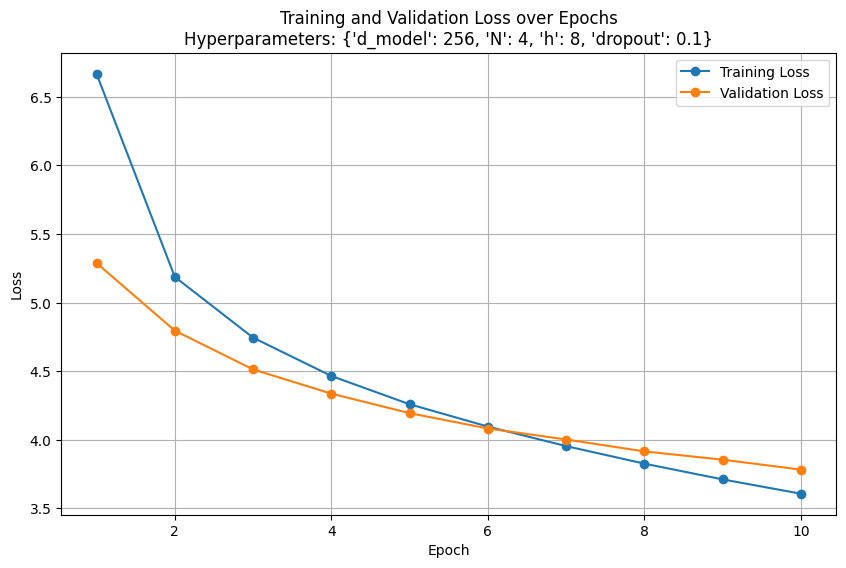

                                          Prediction  BLEU_Score
0  quand je me suis allé à ma mère , j'ai commenc...    0.178918
1     j'étais un moment dans le <UNK> de la guerre .    0.232523
2                    elle était un <UNK> < /talkid >    0.112457
3  maintenant , le premier dans son premier premi...    0.082145
4  quand je suis entendu , je me suis donc <UNK> ...    0.266259


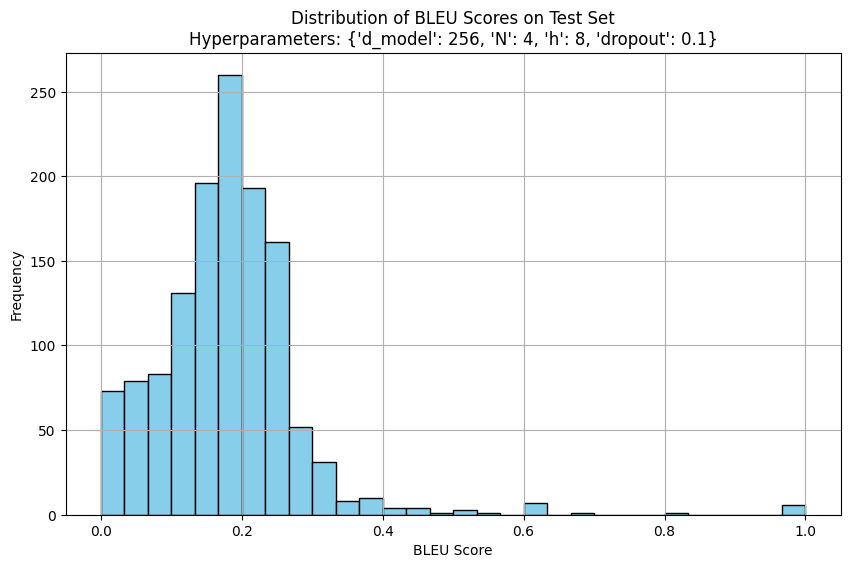

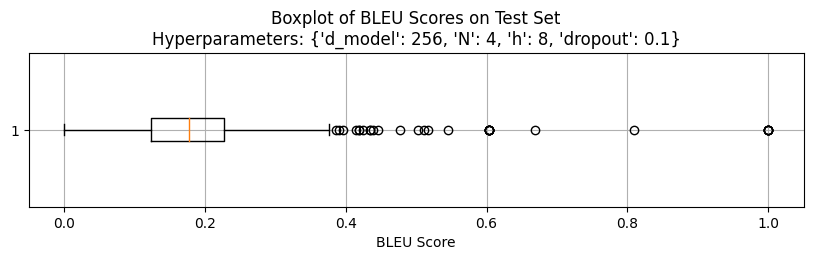

BLEU Score Summary Statistics for Hyperparameters: {'d_model': 256, 'N': 4, 'h': 8, 'dropout': 0.1}
count    1305.000000
mean        0.180546
std         0.105971
min         0.000000
25%         0.124274
50%         0.177544
75%         0.227313
max         1.000000
Name: BLEU_Score, dtype: float64

Training model with hyperparameters: {'d_model': 512, 'N': 6, 'h': 8, 'dropout': 0.1}
Epoch 1, Batch 100, Loss: 5.6721
Epoch 1, Batch 200, Loss: 5.1796
Epoch 1 completed in 104.58s, Average Loss: 5.9170
Validation Loss: 4.7962
Epoch 2, Batch 100, Loss: 4.5093
Epoch 2, Batch 200, Loss: 4.2901
Epoch 2 completed in 104.81s, Average Loss: 4.5986
Validation Loss: 4.2733
Epoch 3, Batch 100, Loss: 4.0714
Epoch 3, Batch 200, Loss: 3.8611
Epoch 3 completed in 104.81s, Average Loss: 4.1188
Validation Loss: 4.0527
Epoch 4, Batch 100, Loss: 4.0910
Epoch 4, Batch 200, Loss: 3.8563
Epoch 4 completed in 104.71s, Average Loss: 3.8029
Validation Loss: 3.8314
Epoch 5, Batch 100, Loss: 3.6262
Epoch 5, Batch 

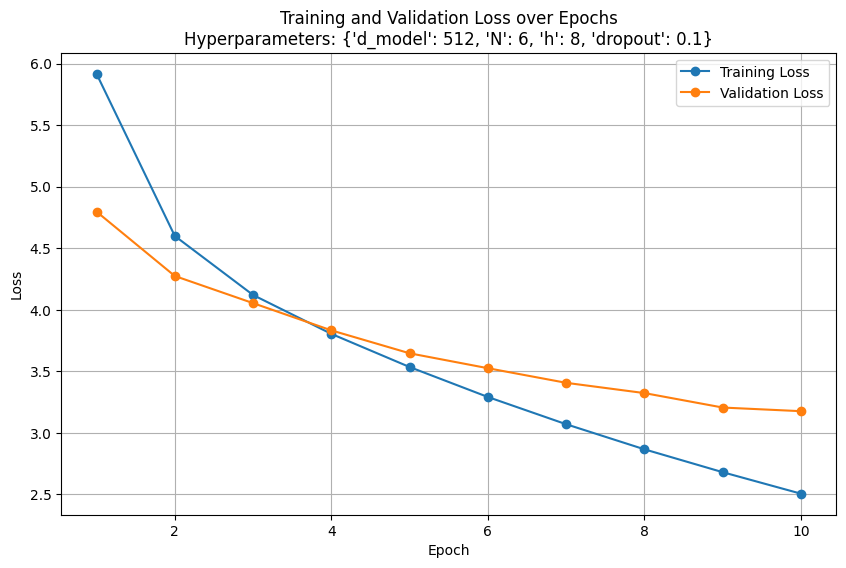

                                          Prediction  BLEU_Score
0  quand j'étais dans mon mari , j'ai vu mon prem...    0.156812
1   j'étais un <UNK> en psychologie de psychologie .    0.182277
2        elle était une femme <UNK> < /description >    0.149696
3  maintenant , le dr dans son premier ministre d...    0.038785
4  quand j'ai entendu cette question , j'étais si...    0.247746


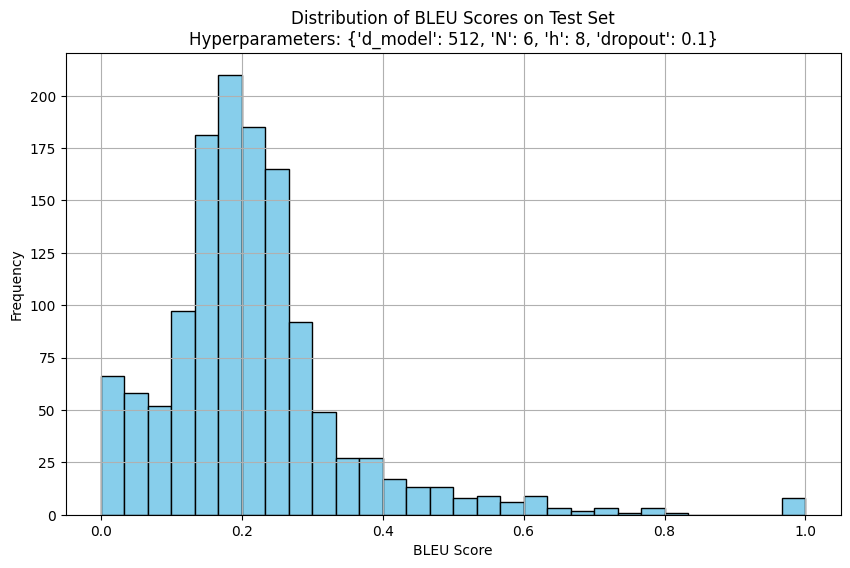

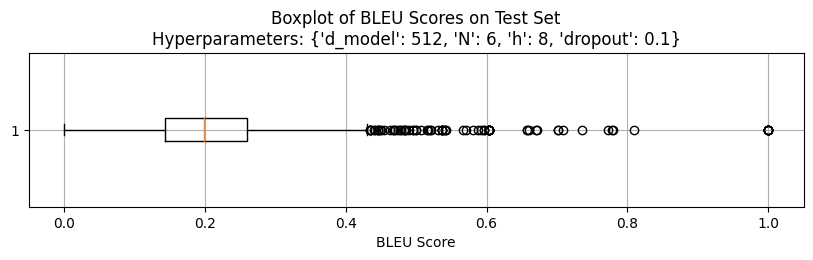

BLEU Score Summary Statistics for Hyperparameters: {'d_model': 512, 'N': 6, 'h': 8, 'dropout': 0.1}
count    1305.000000
mean        0.216528
std         0.135405
min         0.000000
25%         0.143317
50%         0.198755
75%         0.259719
max         1.000000
Name: BLEU_Score, dtype: float64

Training model with hyperparameters: {'d_model': 256, 'N': 4, 'h': 4, 'dropout': 0.2}
Epoch 1, Batch 100, Loss: 6.4750
Epoch 1, Batch 200, Loss: 5.6550
Epoch 1 completed in 43.44s, Average Loss: 6.6516
Validation Loss: 5.3216
Epoch 2, Batch 100, Loss: 5.3275
Epoch 2, Batch 200, Loss: 4.9885
Epoch 2 completed in 43.56s, Average Loss: 5.2608
Validation Loss: 4.8280
Epoch 3, Batch 100, Loss: 4.8978
Epoch 3, Batch 200, Loss: 4.8167
Epoch 3 completed in 43.47s, Average Loss: 4.8205
Validation Loss: 4.5440
Epoch 4, Batch 100, Loss: 4.5035
Epoch 4, Batch 200, Loss: 4.4852
Epoch 4 completed in 43.47s, Average Loss: 4.5452
Validation Loss: 4.3637
Epoch 5, Batch 100, Loss: 4.1785
Epoch 5, Batch 200,

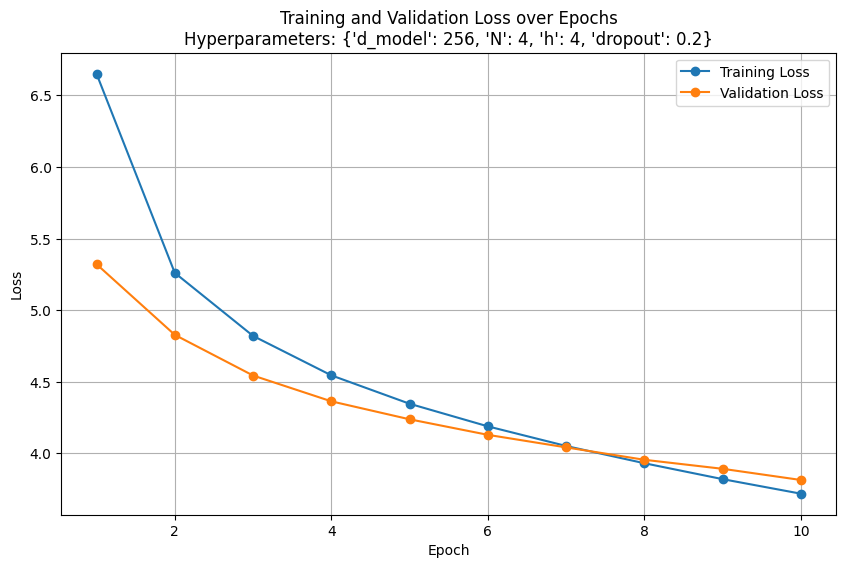

                                          Prediction  BLEU_Score
0  quand j'étais dans mon père , j'ai vu mon prem...    0.193324
1     j'étais une photo de la maison dans les pays .    0.232523
2                       elle était un <UNK> < /url .    0.133734
3  maintenant , les <UNK> dans sa femme et <UNK> ...    0.029215
4  quand je suis donc , je suis donc je suis donc...    0.189681


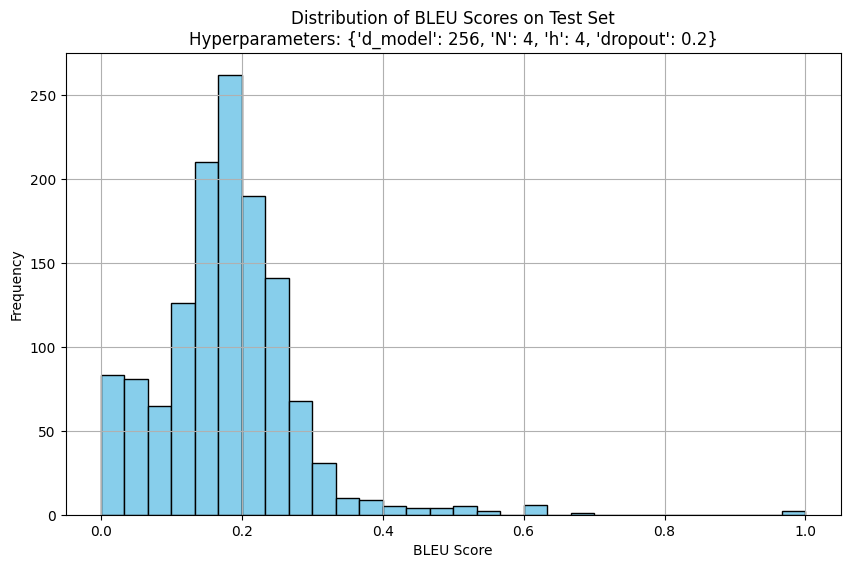

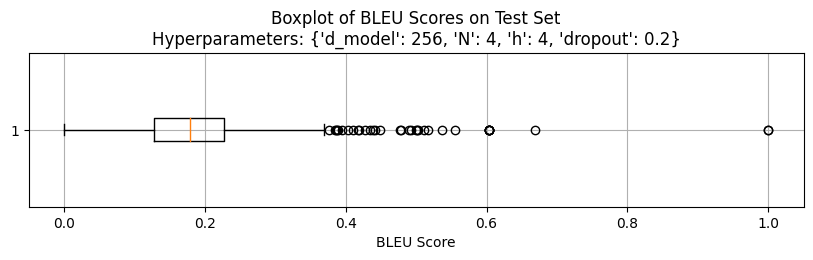

BLEU Score Summary Statistics for Hyperparameters: {'d_model': 256, 'N': 4, 'h': 4, 'dropout': 0.2}
count    1305.000000
mean        0.178715
std         0.097108
min         0.000000
25%         0.128343
50%         0.178918
75%         0.227648
max         1.000000
Name: BLEU_Score, dtype: float64

Training model with hyperparameters: {'d_model': 128, 'N': 2, 'h': 4, 'dropout': 0.1}
Epoch 1, Batch 100, Loss: 7.8482
Epoch 1, Batch 200, Loss: 6.8044
Epoch 1 completed in 27.56s, Average Loss: 7.7716
Validation Loss: 6.1768
Epoch 2, Batch 100, Loss: 6.0990
Epoch 2, Batch 200, Loss: 5.9329
Epoch 2 completed in 27.67s, Average Loss: 6.0328
Validation Loss: 5.4717
Epoch 3, Batch 100, Loss: 5.5549
Epoch 3, Batch 200, Loss: 5.3932
Epoch 3 completed in 27.73s, Average Loss: 5.5445
Validation Loss: 5.1570
Epoch 4, Batch 100, Loss: 5.2491
Epoch 4, Batch 200, Loss: 5.2732
Epoch 4 completed in 27.95s, Average Loss: 5.2409
Validation Loss: 4.9512
Epoch 5, Batch 100, Loss: 5.0403
Epoch 5, Batch 200,

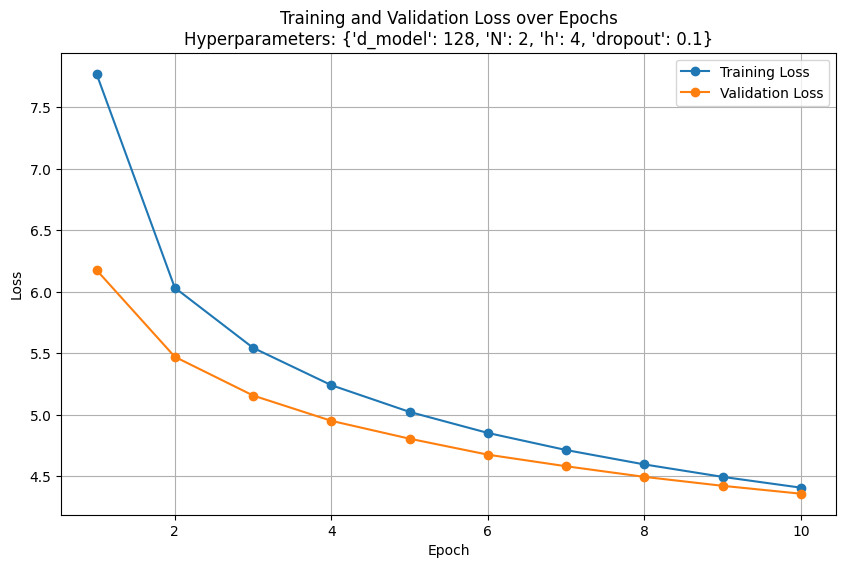

                                          Prediction  BLEU_Score
0  quand je suis allé dans mon père , je suis <UN...    0.249635
1      je suis une fois dans un peu de la première .    0.194068
2                        elle a un <UNK> < /talkid >    0.112457
3  maintenant , les <UNK> de la <UNK> et <UNK> <U...    0.021878
4        quand je suis donc , je suis <UNK> < /url >    0.230787


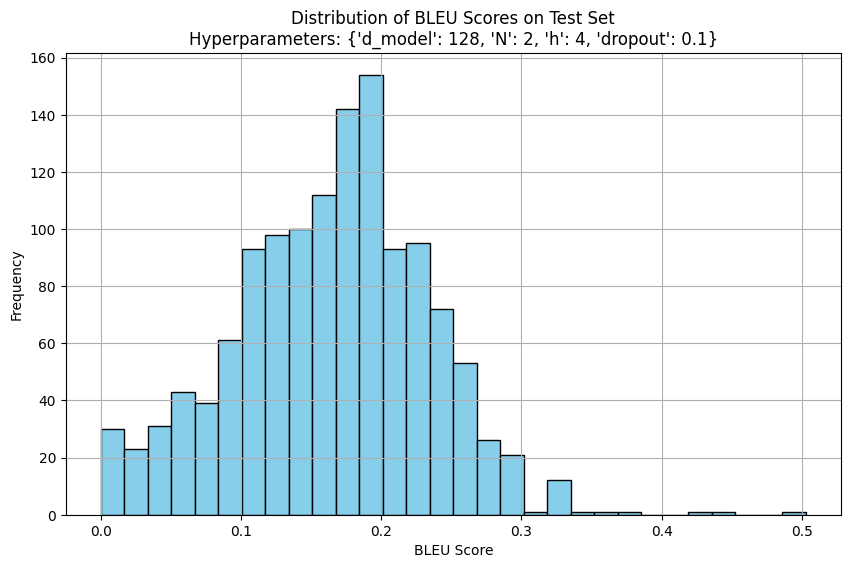

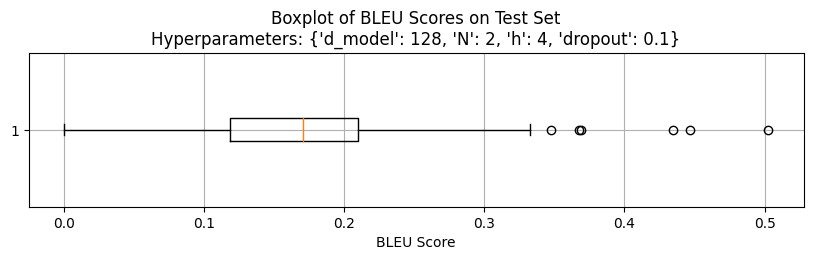

BLEU Score Summary Statistics for Hyperparameters: {'d_model': 128, 'N': 2, 'h': 4, 'dropout': 0.1}
count    1305.000000
mean        0.164696
std         0.069352
min         0.000000
25%         0.118805
50%         0.170367
75%         0.209576
max         0.502659
Name: BLEU_Score, dtype: float64

Results for Hyperparameters: {'d_model': 256, 'N': 4, 'h': 8, 'dropout': 0.1}
Average Training Loss: 3.6070
Average Validation Loss: 3.7825
Average BLEU Score: 0.1805

Results for Hyperparameters: {'d_model': 512, 'N': 6, 'h': 8, 'dropout': 0.1}
Average Training Loss: 2.5040
Average Validation Loss: 3.1747
Average BLEU Score: 0.2165

Results for Hyperparameters: {'d_model': 256, 'N': 4, 'h': 4, 'dropout': 0.2}
Average Training Loss: 3.7185
Average Validation Loss: 3.8143
Average BLEU Score: 0.1787

Results for Hyperparameters: {'d_model': 128, 'N': 2, 'h': 4, 'dropout': 0.1}
Average Training Loss: 4.4081
Average Validation Loss: 4.3590
Average BLEU Score: 0.1647


In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math, copy, time, os
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import numpy as np
import random
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk
import matplotlib.pyplot as plt
import pandas as pd

# Install NLTK data
nltk.download('punkt')

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 1. Data Preparation
class Vocabulary:
    def __init__(self, freq_threshold=2):
        self.freq_threshold = freq_threshold
        self.word2idx = {"<PAD>":0, "<SOS>":1, "<EOS>":2, "<UNK>":3}
        self.idx2word = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"}
        self.word_freq = defaultdict(int)
    
    def build_vocabulary(self, sentence_list):
        for sentence in sentence_list:
            for word in nltk.word_tokenize(sentence.lower()):
                self.word_freq[word] +=1
        for word, freq in self.word_freq.items():
            if freq >= self.freq_threshold:
                self.word2idx[word] = len(self.word2idx)
                self.idx2word[len(self.idx2word)] = word
    
    def numericalize(self, text):
        tokenized = nltk.word_tokenize(text.lower())
        return [self.word2idx.get(token, self.word2idx["<UNK>"]) for token in tokenized]

class TranslationDataset(Dataset):
    def __init__(self, src_file, trg_file, src_vocab, trg_vocab, max_len=50):
        self.src_sentences = []
        self.trg_sentences = []
        with open(src_file, 'r', encoding='utf-8') as f:
            self.src_sentences = f.readlines()
        with open(trg_file, 'r', encoding='utf-8') as f:
            self.trg_sentences = f.readlines()
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab
        self.max_len = max_len
    
    def __len__(self):
        return len(self.src_sentences)
    
    def __getitem__(self, idx):
        src = self.src_sentences[idx].strip()
        trg = self.trg_sentences[idx].strip()
        src_num = [self.src_vocab.word2idx["<SOS>"]]
        src_num += self.src_vocab.numericalize(src)
        src_num.append(self.src_vocab.word2idx["<EOS>"])
        
        trg_num = [self.trg_vocab.word2idx["<SOS>"]]
        trg_num += self.trg_vocab.numericalize(trg)
        trg_num.append(self.trg_vocab.word2idx["<EOS>"])
        
        src_len = len(src_num)
        trg_len = len(trg_num)
        
        if src_len < self.max_len:
            src_num += [self.src_vocab.word2idx["<PAD>"]] * (self.max_len - src_len)
        else:
            src_num = src_num[:self.max_len]
        
        if trg_len < self.max_len:
            trg_num += [self.trg_vocab.word2idx["<PAD>"]] * (self.max_len - trg_len)
        else:
            trg_num = trg_num[:self.max_len]
        
        return torch.tensor(src_num), torch.tensor(trg_num)

# Paths to data
train_src_path = '/kaggle/input/datafiles/data/train.en'
train_trg_path = '/kaggle/input/datafiles/data/train.fr'
dev_src_path = '/kaggle/input/datafiles/data/dev.en'
dev_trg_path = '/kaggle/input/datafiles/data/dev.fr'
test_src_path = '/kaggle/input/datafiles/data/test.en'
test_trg_path = '/kaggle/input/datafiles/data/test.fr'

# Build Vocabularies
with open(train_src_path, 'r', encoding='utf-8') as f:
    train_src = f.readlines()
with open(train_trg_path, 'r', encoding='utf-8') as f:
    train_trg = f.readlines()

SRC_vocab = Vocabulary()
SRC_vocab.build_vocabulary(train_src)

TRG_vocab = Vocabulary()
TRG_vocab.build_vocabulary(train_trg)

print(f"Unique tokens in source (en) vocabulary: {len(SRC_vocab.word2idx)}")
print(f"Unique tokens in target (fr) vocabulary: {len(TRG_vocab.word2idx)}")

# Create Datasets
train_dataset = TranslationDataset(train_src_path, train_trg_path, SRC_vocab, TRG_vocab)
dev_dataset = TranslationDataset(dev_src_path, dev_trg_path, SRC_vocab, TRG_vocab)
test_dataset = TranslationDataset(test_src_path, test_trg_path, SRC_vocab, TRG_vocab)

# Create DataLoaders
BATCH_SIZE = 128

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 2. Model Architecture
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding,self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0,max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0,d_model,2).float() * (-math.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(position * div_term)
        pe[:,1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe',pe)
    
    def forward(self,x):
        x = x + self.pe[:,:x.size(1),:].to(x.device)
        return x

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention,self).__init__()
        assert d_model % h ==0, "d_model must be divisible by h"
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model,d_model),4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            if mask.dim() == 3:
                # self-attn: [batch_size, trg_seq_len, trg_seq_len]
                mask = mask.unsqueeze(1)  # [batch_size,1, trg_seq_len, trg_seq_len]
                mask = mask.expand(-1, self.h, -1, -1)  # [batch_size, h, trg_seq_len, trg_seq_len]
            elif mask.dim() == 2:
                # src-attn: [batch_size, src_seq_len]
                mask = mask.unsqueeze(1).unsqueeze(2)  # [batch_size,1,1, src_seq_len]
                mask = mask.expand(-1, self.h, -1, -1)  # [batch_size, h,1, src_seq_len]
        nbatches = query.size(0)
        
        # 1. Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [l(x).view(nbatches,-1,self.h,self.d_k).transpose(1,2)
                             for l, x in zip(self.linears, (query,key,value))]
        
        # 2. Apply attention on all the projected vectors in batch.
        scores = torch.matmul(query, key.transpose(-2,-1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        p_attn = F.softmax(scores, dim=-1)
        p_attn = self.dropout(p_attn)
        
        # 3. "Concat" using a view and apply a final linear.
        x = torch.matmul(p_attn, value).transpose(1,2).contiguous().view(nbatches,-1,self.h * self.d_k)
        return self.linears[-1](x)

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward,self).__init__()
        self.w_1 = nn.Linear(d_model,d_ff)
        self.w_2 = nn.Linear(d_ff,d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self,x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer,self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.norm1 = nn.LayerNorm(size)
        self.norm2 = nn.LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask):
        # Self-attention sublayer
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        # Feed-forward sublayer
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer,self).__init__()
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.norm1 = nn.LayerNorm(size)
        self.norm2 = nn.LayerNorm(size)
        self.norm3 = nn.LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, memory, src_mask, tgt_mask):
        # Self-attention sublayer
        self_attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(self_attn_output))
        # Source-attention sublayer
        src_attn_output = self.src_attn(x, memory, memory, src_mask)
        x = self.norm2(x + self.dropout(src_attn_output))
        # Feed-forward sublayer
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder,self).__init__()
        self.layers = clones(layer, N)
        self.norm = nn.LayerNorm(layer.self_attn.linears[0].in_features)
    
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder,self).__init__()
        self.layers = clones(layer, N)
        self.norm = nn.LayerNorm(layer.self_attn.linears[0].in_features)
    
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model=256, N=4, h=8, d_ff=1024, dropout=0.1):
        super(Transformer,self).__init__()
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab
        self.d_model = d_model
        
        self.src_embed = nn.Sequential(
            nn.Embedding(len(src_vocab.word2idx), d_model),
            PositionalEncoding(d_model)
        )
        self.trg_embed = nn.Sequential(
            nn.Embedding(len(trg_vocab.word2idx), d_model),
            PositionalEncoding(d_model)
        )
        
        attn = MultiHeadedAttention(h, d_model, dropout)
        ff = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.encoder = Encoder(EncoderLayer(d_model, copy.deepcopy(attn), copy.deepcopy(ff), dropout), N)
        self.decoder = Decoder(DecoderLayer(d_model, copy.deepcopy(attn), copy.deepcopy(attn), copy.deepcopy(ff), dropout), N)
        self.out = nn.Linear(d_model, len(trg_vocab.word2idx))
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, trg, memory, src_mask, trg_mask):
        return self.decoder(self.trg_embed(trg), memory, src_mask, trg_mask)
    
    def forward(self, src, trg, src_mask, trg_mask):
        memory = self.encode(src, src_mask)
        output = self.decode(trg, memory, src_mask, trg_mask)
        return self.out(output)

def make_std_mask(tgt, pad):
    # tgt: [batch_size, trg_seq_len]
    tgt_mask = (tgt != pad).unsqueeze(-2)  # [batch_size,1, trg_seq_len]
    trg_len = tgt.size(1)
    tgt_mask = tgt_mask & subsequent_mask(trg_len).to(tgt.device)  # [batch_size, trg_seq_len, trg_seq_len]
    return tgt_mask

def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(torch.uint8)
    return subsequent_mask == 0

# 3. Training

def train_model(model, train_loader, dev_loader, optimizer, criterion, epochs, trg_pad_idx):
    model.train()
    train_losses = []
    val_losses = []
    
    for epoch in range(1, epochs+1):
        start_time = time.time()
        total_loss = 0
        for i, (src, trg) in enumerate(train_loader):
            src = src.to(device)
            trg = trg.to(device)
            optimizer.zero_grad()
            src_mask = (src != SRC_vocab.word2idx["<PAD>"]).to(device)  # [batch_size, src_seq_len]
            trg_input = trg[:, :-1]  # [batch_size, trg_seq_len -1]
            trg_output = trg[:,1:]   # [batch_size, trg_seq_len -1]
            trg_mask = make_std_mask(trg_input, trg_pad_idx)  # [batch_size, trg_seq_len -1, trg_seq_len -1]
            output = model(src, trg_input, src_mask, trg_mask)  # [batch_size, trg_seq_len -1, trg_vocab_size]
            output = output.view(-1, output.size(-1))  # [batch_size * (trg_seq_len -1), trg_vocab_size]
            trg_output = trg_output.contiguous().view(-1)  # [batch_size * (trg_seq_len -1)]
            loss = criterion(output, trg_output)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            total_loss += loss.item()
            if (i+1) % 100 ==0:
                print(f"Epoch {epoch}, Batch {i+1}, Loss: {loss.item():.4f}")
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch} completed in {time.time()-start_time:.2f}s, Average Loss: {avg_loss:.4f}")
        val_loss = evaluate(model, dev_loader, criterion, trg_pad_idx)
        val_losses.append(val_loss)
    return train_losses, val_losses

def evaluate(model, dev_loader, criterion, trg_pad_idx):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, trg in dev_loader:
            src = src.to(device)
            trg = trg.to(device)
            src_mask = (src != SRC_vocab.word2idx["<PAD>"]).to(device)  # [1, src_seq_len]
            trg_input = trg[:, :-1]  # [1, trg_seq_len -1]
            trg_output = trg[:,1:]   # [1, trg_seq_len -1]
            trg_mask = make_std_mask(trg_input, trg_pad_idx)  # [1, trg_seq_len -1, trg_seq_len -1]
            output = model(src, trg_input, src_mask, trg_mask)  # [1, trg_seq_len -1, trg_vocab_size]
            output = output.view(-1, output.size(-1))  # [1 * (trg_seq_len -1), trg_vocab_size]
            trg_output = trg_output.contiguous().view(-1)  # [1 * (trg_seq_len -1)]
            loss = criterion(output, trg_output)
            total_loss += loss.item()
    avg_loss = total_loss / len(dev_loader)
    print(f"Validation Loss: {avg_loss:.4f}")
    model.train()
    return avg_loss

# 5. Testing and BLEU Score Calculation

def translate_sentence(model, sentence, src_vocab, trg_vocab, max_len=50):
    model.eval()
    tokens = ["<SOS>"] + nltk.word_tokenize(sentence.lower()) + ["<EOS>"]
    src_indexes = [src_vocab.word2idx.get(word, src_vocab.word2idx["<UNK>"]) for word in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)  # [1, src_seq_len]
    src_mask = (src_tensor != src_vocab.word2idx["<PAD>"]).to(device)  # [1, src_seq_len]
    memory = model.encode(src_tensor, src_mask)  # [1, src_seq_len, d_model]
    
    trg_indexes = [trg_vocab.word2idx["<SOS>"]]
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)  # [1, trg_seq_len]
        trg_mask = make_std_mask(trg_tensor, trg_vocab.word2idx["<PAD>"])  # [1, trg_seq_len, trg_seq_len]
        output = model.decode(trg_tensor, memory, src_mask, trg_mask)  # [1, trg_seq_len, d_model]
        output = model.out(output)  # [1, trg_seq_len, trg_vocab_size]
        prob = F.softmax(output, dim=-1)
        _, next_word = torch.max(prob, dim=-1)  # [1, trg_seq_len]
        next_word = next_word[:,-1].item()
        trg_indexes.append(next_word)
        if next_word == trg_vocab.word2idx["<EOS>"]:
            break
    trg_tokens = [trg_vocab.idx2word[i] for i in trg_indexes]
    return trg_tokens[1:]  # Exclude <SOS>

def compute_bleu(model, data_loader, src_vocab, trg_vocab, output_file='testbleu.txt'):
    model.eval()
    smoothie = SmoothingFunction().method4
    bleu_scores = []
    with open(output_file, 'w', encoding='utf-8') as f:
        for src, trg in data_loader:
            # src and trg are tensors with shape [1, max_len]
            src = src.to(device)
            trg = trg.to(device)
            
            # Convert source indices to words
            src_indices = src[0]  # Shape: [max_len]
            src_tokens = [src_vocab.idx2word[idx.item()] for idx in src_indices 
                          if idx.item() not in [src_vocab.word2idx["<SOS>"], 
                                                src_vocab.word2idx["<EOS>"], 
                                                src_vocab.word2idx["<PAD>"]]]
            src_sentence = ' '.join(src_tokens)
            
            # Convert target indices to words
            trg_indices = trg[0]  # Shape: [max_len]
            trg_tokens = [trg_vocab.idx2word[idx.item()] for idx in trg_indices 
                          if idx.item() not in [trg_vocab.word2idx["<SOS>"], 
                                                trg_vocab.word2idx["<EOS>"], 
                                                trg_vocab.word2idx["<PAD>"]]]
            trg_sentence = ' '.join(trg_tokens)
            
            # Generate prediction
            pred_tokens = translate_sentence(model, src_sentence, src_vocab, trg_vocab)
            pred_sentence = ' '.join(pred_tokens[:-1]) if pred_tokens[-1] == "<EOS>" else ' '.join(pred_tokens)
            
            # Compute BLEU score
            bleu_score = sentence_bleu([trg_sentence.split()], pred_sentence.split(), 
                                       smoothing_function=smoothie)
            bleu_scores.append(bleu_score)
            
            # Write to file
            f.write(f"{pred_sentence}\t{bleu_score}\n")
    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    print(f"Average BLEU score: {avg_bleu:.4f}")
    print(f"BLEU scores saved to {output_file}")
    return bleu_scores

# 3.3 Hyperparameter Tuning

# Define hyperparameter combinations
hyperparameter_combinations = [
    {'d_model': 256, 'N': 4, 'h': 8, 'dropout': 0.1},
    {'d_model': 512, 'N': 6, 'h': 8, 'dropout': 0.1},
    {'d_model': 256, 'N': 4, 'h': 4, 'dropout': 0.2},
    {'d_model': 128, 'N': 2, 'h': 4, 'dropout': 0.1},
    # Add more combinations as needed
]

results = []

for idx, params in enumerate(hyperparameter_combinations):
    print(f"\nTraining model with hyperparameters: {params}")
    # Initialize the model
    model = Transformer(SRC_vocab, TRG_vocab, 
                        d_model=params['d_model'], 
                        N=params['N'],
                        h=params['h'], 
                        d_ff=params['d_model']*4,  # Usually d_ff = 4 * d_model
                        dropout=params['dropout']).to(device)
    
    # Initialize optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss(ignore_index=TRG_vocab.word2idx["<PAD>"])
    
    # Train the model
    train_losses, val_losses = train_model(model, train_loader, dev_loader, optimizer, criterion, epochs=10, trg_pad_idx=TRG_vocab.word2idx["<PAD>"])
    
    # Save model state
    model_file = f"transformer_model_{idx}.pt"
    torch.save(model.state_dict(), model_file)
    print(f"Model saved to {model_file}")
    
    # Compute BLEU scores on the test set
    bleu_scores = compute_bleu(model, test_loader, SRC_vocab, TRG_vocab, output_file=f'testbleu_{idx}.txt')
    
    # Store results
    results.append({
        'params': params,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'bleu_scores': bleu_scores,
        'avg_bleu': sum(bleu_scores)/len(bleu_scores),
    })

    # Plot Training and Validation Loss
    epochs_list = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10,6))
    plt.plot(epochs_list, train_losses, label='Training Loss', marker='o')
    plt.plot(epochs_list, val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"Training and Validation Loss over Epochs\nHyperparameters: {params}")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Read BLEU scores from the file
    bleu_data = pd.read_csv(f'testbleu_{idx}.txt', sep='\t', header=None, names=['Prediction', 'BLEU_Score'])
    print(bleu_data.head())
    
    # Plot BLEU Score Distribution
    plt.figure(figsize=(10,6))
    plt.hist(bleu_data['BLEU_Score'], bins=30, color='skyblue', edgecolor='black')
    plt.xlabel('BLEU Score')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of BLEU Scores on Test Set\nHyperparameters: {params}')
    plt.grid(True)
    plt.show()
    
    # Plot BLEU Score Boxplot
    plt.figure(figsize=(10,2))
    plt.boxplot(bleu_data['BLEU_Score'], vert=False)
    plt.xlabel('BLEU Score')
    plt.title(f'Boxplot of BLEU Scores on Test Set\nHyperparameters: {params}')
    plt.grid(True)
    plt.show()
    
    # Display summary statistics
    print(f"BLEU Score Summary Statistics for Hyperparameters: {params}")
    print(bleu_data['BLEU_Score'].describe())

# Compare the results
for idx, res in enumerate(results):
    print(f"\nResults for Hyperparameters: {res['params']}")
    print(f"Average Training Loss: {res['train_losses'][-1]:.4f}")
    print(f"Average Validation Loss: {res['val_losses'][-1]:.4f}")
    print(f"Average BLEU Score: {res['avg_bleu']:.4f}")


In [3]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math, copy, time, os
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import numpy as np
import random
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk
import matplotlib.pyplot as plt
import pandas as pd

# Install NLTK data
nltk.download('punkt')

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 1. Data Preparation
class Vocabulary:
    def __init__(self, freq_threshold=2):
        self.freq_threshold = freq_threshold
        self.word2idx = {"<PAD>":0, "<SOS>":1, "<EOS>":2, "<UNK>":3}
        self.idx2word = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"}
        self.word_freq = defaultdict(int)
    
    def build_vocabulary(self, sentence_list):
        for sentence in sentence_list:
            for word in nltk.word_tokenize(sentence.lower()):
                self.word_freq[word] +=1
        for word, freq in self.word_freq.items():
            if freq >= self.freq_threshold:
                self.word2idx[word] = len(self.word2idx)
                self.idx2word[len(self.idx2word)] = word
    
    def numericalize(self, text):
        tokenized = nltk.word_tokenize(text.lower())
        return [self.word2idx.get(token, self.word2idx["<UNK>"]) for token in tokenized]

class TranslationDataset(Dataset):
    def __init__(self, src_file, trg_file, src_vocab, trg_vocab, max_len=50):
        self.src_sentences = []
        self.trg_sentences = []
        with open(src_file, 'r', encoding='utf-8') as f:
            self.src_sentences = f.readlines()
        with open(trg_file, 'r', encoding='utf-8') as f:
            self.trg_sentences = f.readlines()
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab
        self.max_len = max_len
    
    def __len__(self):
        return len(self.src_sentences)
    
    def __getitem__(self, idx):
        src = self.src_sentences[idx].strip()
        trg = self.trg_sentences[idx].strip()
        src_num = [self.src_vocab.word2idx["<SOS>"]]
        src_num += self.src_vocab.numericalize(src)
        src_num.append(self.src_vocab.word2idx["<EOS>"])
        
        trg_num = [self.trg_vocab.word2idx["<SOS>"]]
        trg_num += self.trg_vocab.numericalize(trg)
        trg_num.append(self.trg_vocab.word2idx["<EOS>"])
        
        src_len = len(src_num)
        trg_len = len(trg_num)
        
        if src_len < self.max_len:
            src_num += [self.src_vocab.word2idx["<PAD>"]] * (self.max_len - src_len)
        else:
            src_num = src_num[:self.max_len]
        
        if trg_len < self.max_len:
            trg_num += [self.trg_vocab.word2idx["<PAD>"]] * (self.max_len - trg_len)
        else:
            trg_num = trg_num[:self.max_len]
        
        return torch.tensor(src_num), torch.tensor(trg_num)

# Paths to data (Replace these with actual paths)
train_src_path = '/kaggle/input/datafiles/data/train.en'
train_trg_path = '/kaggle/input/datafiles/data/train.fr'
dev_src_path = '/kaggle/input/datafiles/data/dev.en'
dev_trg_path = '/kaggle/input/datafiles/data/dev.fr'
test_src_path = '/kaggle/input/datafiles/data/test.en'
test_trg_path = '/kaggle/input/datafiles/data/test.fr'

# Build Vocabularies
with open(train_src_path, 'r', encoding='utf-8') as f:
    train_src = f.readlines()
with open(train_trg_path, 'r', encoding='utf-8') as f:
    train_trg = f.readlines()

SRC_vocab = Vocabulary()
SRC_vocab.build_vocabulary(train_src)

TRG_vocab = Vocabulary()
TRG_vocab.build_vocabulary(train_trg)

print(f"Unique tokens in source (en) vocabulary: {len(SRC_vocab.word2idx)}")
print(f"Unique tokens in target (fr) vocabulary: {len(TRG_vocab.word2idx)}")

# Create Datasets
train_dataset = TranslationDataset(train_src_path, train_trg_path, SRC_vocab, TRG_vocab)
dev_dataset = TranslationDataset(dev_src_path, dev_trg_path, SRC_vocab, TRG_vocab)
test_dataset = TranslationDataset(test_src_path, test_trg_path, SRC_vocab, TRG_vocab)

# Create DataLoaders
BATCH_SIZE = 128  # Reduced from 128 to 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 2. Model Architecture
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding,self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0,max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0,d_model,2).float() * (-math.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(position * div_term)
        pe[:,1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe',pe)
    
    def forward(self,x):
        x = x + self.pe[:,:x.size(1),:].to(x.device)
        return x

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention,self).__init__()
        assert d_model % h ==0, "d_model must be divisible by h"
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model,d_model),4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            if mask.dim() == 3:
                # self-attn: [batch_size, trg_seq_len, trg_seq_len]
                mask = mask.unsqueeze(1)  # [batch_size,1, trg_seq_len, trg_seq_len]
                mask = mask.expand(-1, self.h, -1, -1)  # [batch_size, h, trg_seq_len, trg_seq_len]
            elif mask.dim() == 2:
                # src-attn: [batch_size, src_seq_len]
                mask = mask.unsqueeze(1).unsqueeze(2)  # [batch_size,1,1, src_seq_len]
                mask = mask.expand(-1, self.h, -1, -1)  # [batch_size, h,1, src_seq_len]
        nbatches = query.size(0)
        
        # 1. Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [l(x).view(nbatches,-1,self.h,self.d_k).transpose(1,2)
                             for l, x in zip(self.linears, (query,key,value))]
        
        # 2. Apply attention on all the projected vectors in batch.
        scores = torch.matmul(query, key.transpose(-2,-1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e4)  # Replaced -1e9 with -1e4
        p_attn = F.softmax(scores, dim=-1)
        p_attn = self.dropout(p_attn)
        
        # 3. "Concat" using a view and apply a final linear.
        x = torch.matmul(p_attn, value).transpose(1,2).contiguous().view(nbatches,-1,self.h * self.d_k)
        return self.linears[-1](x)

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward,self).__init__()
        self.w_1 = nn.Linear(d_model,d_ff)
        self.w_2 = nn.Linear(d_ff,d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self,x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer,self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.norm1 = nn.LayerNorm(size)
        self.norm2 = nn.LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask):
        # Self-attention sublayer
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        # Feed-forward sublayer
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer,self).__init__()
        self.self_attn = self_attn      # Corrected assignment
        self.src_attn = src_attn        # Corrected assignment
        self.feed_forward = feed_forward  # Corrected assignment
        self.norm1 = nn.LayerNorm(size)
        self.norm2 = nn.LayerNorm(size)
        self.norm3 = nn.LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, memory, src_mask, tgt_mask):
        # Self-attention sublayer
        self_attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(self_attn_output))
        # Source-attention sublayer
        src_attn_output = self.src_attn(x, memory, memory, src_mask)
        x = self.norm2(x + self.dropout(src_attn_output))
        # Feed-forward sublayer
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder,self).__init__()
        self.layers = clones(layer, N)
        self.norm = nn.LayerNorm(layer.self_attn.linears[0].in_features)
    
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder,self).__init__()
        self.layers = clones(layer, N)
        self.norm = nn.LayerNorm(layer.self_attn.linears[0].in_features)
    
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model=256, N=4, h=8, d_ff=1024, dropout=0.1):
        super(Transformer,self).__init__()
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab
        self.d_model = d_model
        
        self.src_embed = nn.Sequential(
            nn.Embedding(len(src_vocab.word2idx), d_model),
            PositionalEncoding(d_model)
        )
        self.trg_embed = nn.Sequential(
            nn.Embedding(len(trg_vocab.word2idx), d_model),
            PositionalEncoding(d_model)
        )
        
        attn = MultiHeadedAttention(h, d_model, dropout)
        ff = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.encoder = Encoder(EncoderLayer(d_model, copy.deepcopy(attn), copy.deepcopy(ff), dropout), N)
        self.decoder = Decoder(DecoderLayer(d_model, copy.deepcopy(attn), copy.deepcopy(attn), copy.deepcopy(ff), dropout), N)
        self.out = nn.Linear(d_model, len(trg_vocab.word2idx))
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, trg, memory, src_mask, trg_mask):
        return self.decoder(self.trg_embed(trg), memory, src_mask, trg_mask)
    
    def forward(self, src, trg, src_mask, trg_mask):
        memory = self.encode(src, src_mask)
        output = self.decode(trg, memory, src_mask, trg_mask)
        return self.out(output)

def make_std_mask(tgt, pad):
    # tgt: [batch_size, trg_seq_len]
    tgt_mask = (tgt != pad).unsqueeze(-2)  # [batch_size,1, trg_seq_len]
    trg_len = tgt.size(1)
    tgt_mask = tgt_mask & subsequent_mask(trg_len).to(tgt.device)  # [batch_size, trg_seq_len, trg_seq_len]
    return tgt_mask

def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(torch.bool)
    return subsequent_mask == 0

# 3. Training

from torch.amp import GradScaler, autocast  # Updated import as per PyTorch's latest API

def train_model(model, train_loader, dev_loader, optimizer, criterion, epochs, trg_pad_idx):
    model.train()
    train_losses = []
    val_losses = []
    scaler = GradScaler(device='cuda')  # Updated GradScaler initialization
    
    for epoch in range(1, epochs+1):
        start_time = time.time()
        total_loss = 0
        for i, (src, trg) in enumerate(train_loader):
            src = src.to(device)
            trg = trg.to(device)
            optimizer.zero_grad()
            src_mask = (src != SRC_vocab.word2idx["<PAD>"]).to(device)  # [batch_size, src_seq_len]
            trg_input = trg[:, :-1]  # [batch_size, trg_seq_len -1]
            trg_output = trg[:,1:]   # [batch_size, trg_seq_len -1]
            trg_mask = make_std_mask(trg_input, trg_pad_idx)  # [batch_size, trg_seq_len -1, trg_seq_len -1]
            
            with autocast(device_type='cuda'):  # Updated autocast usage
                output = model(src, trg_input, src_mask, trg_mask)  # [batch_size, trg_seq_len -1, trg_vocab_size]
                output = output.view(-1, output.size(-1))  # [batch_size * (trg_seq_len -1), trg_vocab_size]
                trg_output = trg_output.contiguous().view(-1)  # [batch_size * (trg_seq_len -1)]
                loss = criterion(output, trg_output)
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()
            if (i+1) % 100 ==0:
                print(f"Epoch {epoch}, Batch {i+1}, Loss: {loss.item():.4f}")
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch} completed in {time.time()-start_time:.2f}s, Average Loss: {avg_loss:.4f}")
        val_loss = evaluate(model, dev_loader, criterion, trg_pad_idx)
        val_losses.append(val_loss)
    return train_losses, val_losses

def evaluate(model, dev_loader, criterion, trg_pad_idx):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, trg in dev_loader:
            src = src.to(device)
            trg = trg.to(device)
            src_mask = (src != SRC_vocab.word2idx["<PAD>"]).to(device)  # [1, src_seq_len]
            trg_input = trg[:, :-1]  # [1, trg_seq_len -1]
            trg_output = trg[:,1:]   # [1, trg_seq_len -1]
            trg_mask = make_std_mask(trg_input, trg_pad_idx)  # [1, trg_seq_len -1, trg_seq_len -1]
            with autocast(device_type='cuda'):
                output = model(src, trg_input, src_mask, trg_mask)  # [1, trg_seq_len -1, trg_vocab_size]
                output = output.view(-1, output.size(-1))  # [1 * (trg_seq_len -1), trg_vocab_size]
                trg_output = trg_output.contiguous().view(-1)  # [1 * (trg_seq_len -1)]
                loss = criterion(output, trg_output)
                total_loss += loss.item()
    avg_loss = total_loss / len(dev_loader)
    print(f"Validation Loss: {avg_loss:.4f}")
    model.train()
    return avg_loss

# 4. Hyperparameter Tuning

# Define different hyperparameter configurations
hyperparameter_configs = [
    {
        'name': 'Config_1_Baseline',
        'd_model': 256,
        'N': 4,
        'h': 8,
        'd_ff': 1024,
        'dropout': 0.1,
        'lr': 0.0001
    },
    {
        'name': 'Config_2_Small',
        'd_model': 128,  # Smaller model size
        'N': 3,          # Fewer encoder-decoder layers
        'h': 4,          # Fewer attention heads
        'd_ff': 512,     # Smaller feed-forward network
        'dropout': 0.2,  # Higher dropout for regularization
        'lr': 0.0005     # Slightly higher learning rate
    },
    {
        'name': 'Config_3_Large',
        'd_model': 512,  # Larger model size
        'N': 6,          # More encoder-decoder layers
        'h': 8,          # Standard number of attention heads
        'd_ff': 2048,    # Larger feed-forward network
        'dropout': 0.1,  # Standard dropout
        'lr': 0.00005    # Smaller learning rate for stability
    },
    {
        'name': 'Config_4_Wide_Attention',
        'd_model': 256,  # Medium model size
        'N': 4,          # Moderate number of layers
        'h': 16,         # More attention heads
        'd_ff': 1024,    # Standard feed-forward size
        'dropout': 0.15, # Moderate dropout
        'lr': 0.0002     # Slightly higher learning rate
    }
]


# Function to translate a sentence using the trained model
def translate_sentence(model, sentence, src_vocab, trg_vocab, max_len=50):
    model.eval()
    tokens = ["<SOS>"] + nltk.word_tokenize(sentence.lower()) + ["<EOS>"]
    src_indexes = [src_vocab.word2idx.get(word, src_vocab.word2idx["<UNK>"]) for word in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)  # [1, src_seq_len]
    src_mask = (src_tensor != src_vocab.word2idx["<PAD>"]).to(device)  # [1, src_seq_len]
    memory = model.encode(src_tensor, src_mask)  # [1, src_seq_len, d_model]
    
    trg_indexes = [trg_vocab.word2idx["<SOS>"]]
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)  # [1, trg_seq_len]
        trg_mask = make_std_mask(trg_tensor, trg_vocab.word2idx["<PAD>"])  # [1, trg_seq_len, trg_seq_len]
        with torch.no_grad():
            output = model.decode(trg_tensor, memory, src_mask, trg_mask)  # [1, trg_seq_len, d_model]
            output = model.out(output)  # [1, trg_seq_len, trg_vocab_size]
            prob = F.softmax(output, dim=-1)
            _, next_word = torch.max(prob, dim=-1)  # [1, trg_seq_len]
            next_word = next_word[:,-1].item()
            trg_indexes.append(next_word)
            if next_word == trg_vocab.word2idx["<EOS>"]:
                break
    trg_tokens = [trg_vocab.idx2word[i] for i in trg_indexes]
    return trg_tokens[1:]  # Exclude <SOS>

# Function to compute BLEU scores and save them to a file
def compute_bleu(model, data_loader, src_vocab, trg_vocab, output_file='testbleu.txt'):
    model.eval()
    smoothie = SmoothingFunction().method4
    bleu_scores = []
    with open(output_file, 'w', encoding='utf-8') as f:
        for src, trg in data_loader:
            # src and trg are tensors with shape [1, max_len]
            src = src.to(device)
            trg = trg.to(device)
            
            # Convert source indices to words
            src_indices = src[0]  # Shape: [max_len]
            src_tokens = [src_vocab.idx2word[idx.item()] for idx in src_indices 
                          if idx.item() not in [src_vocab.word2idx["<SOS>"], 
                                                src_vocab.word2idx["<EOS>"], 
                                                src_vocab.word2idx["<PAD>"]]]
            src_sentence = ' '.join(src_tokens)
            
            # Convert target indices to words
            trg_indices = trg[0]  # Shape: [max_len]
            trg_tokens = [trg_vocab.idx2word[idx.item()] for idx in trg_indices 
                          if idx.item() not in [trg_vocab.word2idx["<SOS>"], 
                                                trg_vocab.word2idx["<EOS>"], 
                                                trg_vocab.word2idx["<PAD>"]]]
            trg_sentence = ' '.join(trg_tokens)
            
            # Generate prediction
            pred_tokens = translate_sentence(model, src_sentence, src_vocab, trg_vocab)
            pred_sentence = ' '.join(pred_tokens[:-1]) if pred_tokens[-1] == "<EOS>" else ' '.join(pred_tokens)
            
            # Compute BLEU score
            bleu_score = sentence_bleu([trg_sentence.split()], pred_sentence.split(), 
                                       smoothing_function=smoothie)
            bleu_scores.append(bleu_score)
            
            # Write to file
            f.write(f"{pred_sentence}\t{bleu_score}\n")
    print(f"BLEU scores saved to {output_file}")
    return bleu_scores

# Function to train and evaluate a single hyperparameter configuration
def run_experiment(config, train_loader, dev_loader, test_loader, SRC_vocab, TRG_vocab, epochs=10):
    print(f"\nStarting experiment with {config['name']}")
    print(f"Hyperparameters: {config}")
    
    # Initialize the model
    model = Transformer(
        src_vocab=SRC_vocab, 
        trg_vocab=TRG_vocab, 
        d_model=config['d_model'], 
        N=config['N'],
        h=config['h'], 
        d_ff=config['d_ff'], 
        dropout=config['dropout']
    ).to(device)
    
    # Initialize optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    criterion = nn.CrossEntropyLoss(ignore_index=TRG_vocab.word2idx["<PAD>"])
    
    # Train the model
    train_losses, val_losses = train_model(
        model, train_loader, dev_loader, optimizer, 
        criterion, epochs, trg_pad_idx=TRG_vocab.word2idx["<PAD>"]
    )
    
    # Save loss histories
    loss_history = {
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    torch.save(loss_history, f'{config["name"]}_loss_history.pt')
    
    # Save the trained model
    torch.save(model.state_dict(), f'{config["name"]}_transformer.pt')
    
    # Plot Training and Validation Loss
    plt.figure(figsize=(10,6))
    plt.plot(range(1, epochs+1), train_losses, label='Training Loss', marker='o')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss over Epochs for {config["name"]}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{config["name"]}_loss_plot.png')
    plt.close()
    
    # Evaluate on Test Set and Compute BLEU Scores
    bleu_scores = compute_bleu(model, test_loader, SRC_vocab, TRG_vocab, output_file=f'{config["name"]}_testbleu.txt')
    
    # Plot BLEU Score Distribution
    bleu_data = pd.read_csv(f'{config["name"]}_testbleu.txt', sep='\t', header=None, names=['Prediction', 'BLEU_Score'])
    
    plt.figure(figsize=(10,6))
    plt.hist(bleu_data['BLEU_Score'], bins=30, color='skyblue', edgecolor='black')
    plt.xlabel('BLEU Score')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of BLEU Scores on Test Set for {config["name"]}')
    plt.grid(True)
    plt.savefig(f'{config["name"]}_bleu_distribution.png')
    plt.close()
    
    # Plot BLEU Score Boxplot
    plt.figure(figsize=(10,2))
    plt.boxplot(bleu_data['BLEU_Score'], vert=False)
    plt.xlabel('BLEU Score')
    plt.title(f'Boxplot of BLEU Scores on Test Set for {config["name"]}')
    plt.grid(True)
    plt.savefig(f'{config["name"]}_bleu_boxplot.png')
    plt.close()
    
    # Display summary statistics
    summary = bleu_data['BLEU_Score'].describe()
    print(f"BLEU Score Summary for {config['name']}:")
    print(summary)
    
    # Save summary statistics
    summary.to_csv(f'{config["name"]}_bleu_summary.csv')
    
    return {
        'config': config,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'bleu_scores': bleu_data['BLEU_Score'],
        'summary': summary
    }

# Run experiments for all hyperparameter configurations
results = []
for config in hyperparameter_configs:
    result = run_experiment(
        config, train_loader, dev_loader, test_loader, 
        SRC_vocab, TRG_vocab, epochs=10
    )
    results.append(result)

# 5. Summary of All Experiments

# Create a DataFrame to summarize BLEU scores
summary_data = []
for res in results:
    config_name = res['config']['name']
    mean_bleu = res['bleu_scores'].mean()
    std_bleu = res['bleu_scores'].std()
    summary_data.append({
        'Configuration': config_name,
        'Mean BLEU Score': mean_bleu,
        'STD BLEU Score': std_bleu
    })

summary_df = pd.DataFrame(summary_data)
print("\nSummary of BLEU Scores for All Configurations:")
print(summary_df)

# Save the summary to a CSV file
summary_df.to_csv('hyperparameter_tuning_summary.csv', index=False)

# Plot Mean BLEU Scores for All Configurations
plt.figure(figsize=(8,6))
plt.bar(summary_df['Configuration'], summary_df['Mean BLEU Score'], yerr=summary_df['STD BLEU Score'], 
        capsize=5, color=['blue', 'green'])
plt.xlabel('Configuration')
plt.ylabel('Mean BLEU Score')
plt.title('Comparison of Mean BLEU Scores Across Configurations')
plt.grid(axis='y')
plt.savefig('bleu_score_comparison.png')
plt.close()

print("\nHyperparameter tuning complete. Summary and plots saved.")


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using device: cuda
Unique tokens in source (en) vocabulary: 13344
Unique tokens in target (fr) vocabulary: 17538

Starting experiment with Config_1_Baseline
Hyperparameters: {'name': 'Config_1_Baseline', 'd_model': 256, 'N': 4, 'h': 8, 'd_ff': 1024, 'dropout': 0.1, 'lr': 0.0001}
Epoch 1, Batch 100, Loss: 6.3144
Epoch 1, Batch 200, Loss: 5.6382
Epoch 1 completed in 46.02s, Average Loss: 6.6693
Validation Loss: 5.2934
Epoch 2, Batch 100, Loss: 5.1336
Epoch 2, Batch 200, Loss: 5.0287
Epoch 2 completed in 46.06s, Average Loss: 5.1880
Validation Loss: 4.7949
Epoch 3, Batch 100, Loss: 4.8009
Epoch 3, Batch 200, Loss: 4.5185
Epoch 3 completed in 45.93s, Average Loss: 4.7439
Validation Loss: 4.5127
Epoch 4, Batch 100, Loss: 4.5794
Epoch 4, Batch 200, Loss: 4.5056
Epoch 4 completed in 45.91s, Average Loss: 4.4646
Validation Loss: 4.3359
Epoch 5, Batch 100, Loss: 4.3552
Epoch 5, Ba

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Epoch: 01 | Time: 1m 20s
	Train Loss: 5.876
	 Val. Loss: 5.168
Epoch: 02 | Time: 1m 16s
	Train Loss: 5.042
	 Val. Loss: 4.860
Epoch: 03 | Time: 1m 21s
	Train Loss: 4.752
	 Val. Loss: 4.690
Epoch: 04 | Time: 1m 18s
	Train Loss: 4.572
	 Val. Loss: 4.570
Epoch: 05 | Time: 1m 14s
	Train Loss: 4.436
	 Val. Loss: 4.491
Epoch: 06 | Time: 1m 14s
	Train Loss: 4.324
	 Val. Loss: 4.436
Epoch: 07 | Time: 1m 12s
	Train Loss: 4.229
	 Val. Loss: 4.369
Epoch: 08 | Time: 1m 15s
	Train Loss: 4.141
	 Val. Loss: 4.326
Epoch: 09 | Time: 1m 16s
	Train Loss: 4.065
	 Val. Loss: 4.282
Epoch: 10 | Time: 1m 15s
	Train Loss: 3.989
	 Val. Loss: 4.254


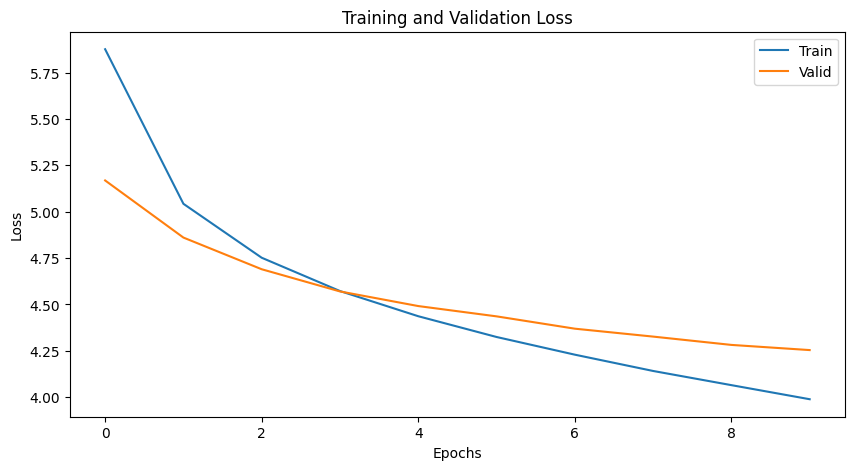

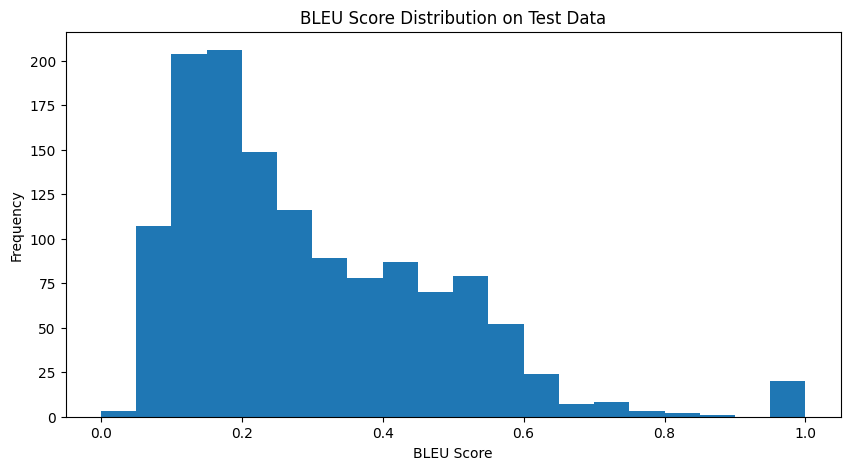

Average BLEU score on test data: 0.2946

Sample Translations:

Source (1): When I was in my 20s, I saw my very first psychotherapy client.
Target (1): Quand j'avais la vingtaine, j'ai vu mes tout premiers clients comme psychothérapeute.
Predicted (1): quand je suis allé , je suis très <UNK> , je suis très <UNK> . <EOS>

Source (2): I was a Ph.D. student in clinical psychology at Berkeley.
Target (2): J'étais étudiante en thèse en psychologie clinique à Berkeley.
Predicted (2): je suis allé dans un groupe de la maison . <EOS>

Source (3): She was a 26-year-old woman named Alex.
Target (3): Elle, c'était une femme de 26 ans appelée Alex.
Predicted (3): elle était un <UNK> <UNK> . <EOS>


RuntimeError: The size of tensor a (43) must match the size of tensor b (40) at non-singleton dimension 0

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import random
import os
import time
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import nltk
import matplotlib.pyplot as plt

# Download punkt tokenizer for NLTK
nltk.download('punkt')

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Adjusted Hyperparameters for Reduced Memory Usage
NUM_EPOCHS = 10
BATCH_SIZE = 16           # Reduced batch size
LEARNING_RATE = 0.0001
EMBED_SIZE = 256          # Reduced embedding size
NUM_HEADS = 4             # Reduced number of heads
NUM_ENCODER_LAYERS = 3    # Reduced number of encoder layers
NUM_DECODER_LAYERS = 3    # Reduced number of decoder layers
FORWARD_EXPANSION = 2     # Reduced forward expansion
DROPOUT = 0.1
PAD_IDX = 0

# Limit maximum sequence length
MAX_LEN = 40             # Reduced maximum sequence length

# Paths to data
DATA_PATH = '/kaggle/input/datafiles/data'  # Update this path to your data directory

# Vocabulary class
class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v: k for k, v in self.itos.items()}

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer(text):
        return nltk.word_tokenize(text.lower())

    def build_vocabulary(self, sentences):
        frequencies = Counter()
        idx = 4

        for sentence in sentences:
            tokens = self.tokenizer(sentence)
            frequencies.update(tokens)

        for word, freq in frequencies.items():
            if freq >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer(text)
        return [
            self.stoi.get(token, self.stoi["<UNK>"]) for token in tokenized_text
        ]

# Custom Dataset
class TranslationDataset(Dataset):
    def __init__(self, src_sentences, trg_sentences, src_vocab, trg_vocab, max_len):
        self.src_sentences = src_sentences
        self.trg_sentences = trg_sentences
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.src_sentences)

    def __getitem__(self, idx):
        src_sentence = self.src_sentences[idx]
        trg_sentence = self.trg_sentences[idx]

        src_tensor = [self.src_vocab.stoi["<SOS>"]] + self.src_vocab.numericalize(src_sentence) + [self.src_vocab.stoi["<EOS>"]]
        trg_tensor = [self.trg_vocab.stoi["<SOS>"]] + self.trg_vocab.numericalize(trg_sentence) + [self.trg_vocab.stoi["<EOS>"]]

        # Truncate sequences longer than max_len
        src_tensor = src_tensor[:self.max_len]
        trg_tensor = trg_tensor[:self.max_len]

        return torch.tensor(src_tensor), torch.tensor(trg_tensor)

# Collate function for DataLoader
def collate_fn(batch):
    src_batch, trg_batch = [], []
    for src_sample, trg_sample in batch:
        src_batch.append(src_sample)
        trg_batch.append(trg_sample)

    src_batch = nn.utils.rnn.pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = nn.utils.rnn.pad_sequence(trg_batch, padding_value=PAD_IDX)

    return src_batch, trg_batch

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, max_len):
        super(PositionalEncoding, self).__init__()
        self.embed_size = embed_size

        pe = torch.zeros(max_len, embed_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-math.log(10000.0) / embed_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        if embed_size % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(0)
        x = x * math.sqrt(self.embed_size)
        if seq_len > self.pe.size(0):
            # Truncate positional encoding to match sequence length
            pe = self.pe[:seq_len, :]
        else:
            pe = self.pe[:seq_len, :]
        x = x + pe
        return x

# Scaled Dot-Product Attention (Modified)
class ScaledDotProductAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(ScaledDotProductAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embed size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys   = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries= nn.Linear(self.head_dim, self.head_dim, bias=False)

        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[1]
        value_len, key_len, query_len = values.shape[0], keys.shape[0], query.shape[0]

        # Split embedding into self.heads pieces
        values  = values.view(value_len, N, self.heads, self.head_dim)
        keys    = keys.view(key_len, N, self.heads, self.head_dim)
        queries = query.view(query_len, N, self.heads, self.head_dim)

        values  = self.values(values)
        keys    = self.keys(keys)
        queries = self.queries(queries)

        # Compute energy
        energy = torch.einsum("qnhd, knhd -> nhqk", [queries, keys])

        if mask is not None:
            # Adjust mask shape to match energy
            # mask shape: (N, 1, 1, key_len)
            # Expand mask to (N, 1, query_len, key_len)
            mask = mask.expand(-1, -1, query_len, key_len)
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        # Attention weights
        attention = torch.softmax(energy / math.sqrt(self.head_dim), dim=3)

        # Compute context vector
        out = torch.einsum("nhql, lnhd -> qnhd", [attention, values]).reshape(
            query_len, N, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = ScaledDotProductAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)

        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

# Encoder
class Encoder(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length,
    ):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = PositionalEncoding(embed_size, max_length)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        # x shape: (seq_length, N)
        N = x.shape[1]

        embeddings = self.dropout(
            self.position_embedding(self.word_embedding(x))
        )

        out = embeddings
        for layer in self.layers:
            out = layer(out, out, out, mask)

        return out

# Decoder Block
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()
        self.attention = ScaledDotProductAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(
            embed_size, heads, dropout, forward_expansion
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, src_mask, trg_mask):
        attention = self.attention(x, x, x, trg_mask)
        query = self.dropout(self.norm(attention + x))
        out = self.transformer_block(value, key, query, src_mask)
        return out

# Decoder
class Decoder(nn.Module):
    def __init__(
        self,
        trg_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        device,
        max_length,
    ):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = PositionalEncoding(embed_size, max_length)

        self.layers = nn.ModuleList(
            [
                DecoderBlock(
                    embed_size,
                    heads,
                    forward_expansion,
                    dropout,
                    device,
                )
                for _ in range(num_layers)
            ]
        )

        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, trg_mask):
        N = x.shape[1]
        embeddings = self.dropout(
            self.position_embedding(self.word_embedding(x))
        )

        out = embeddings
        for layer in self.layers:
            out = layer(out, enc_out, enc_out, src_mask, trg_mask)

        out = self.fc_out(out)
        return out

# Transformer
class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        trg_pad_idx,
        embed_size=EMBED_SIZE,
        num_layers=NUM_ENCODER_LAYERS,
        forward_expansion=FORWARD_EXPANSION,
        heads=NUM_HEADS,
        dropout=DROPOUT,
        device=device,
        max_length=MAX_LEN,
    ):

        super(Transformer, self).__init__()

        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length,
        )

        self.decoder = Decoder(
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            device,
            max_length,
        )

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        # src shape: (src_seq_len, N)
        src_mask = (src != self.src_pad_idx).transpose(0, 1).unsqueeze(1).unsqueeze(2)
        # src_mask shape: (N, 1, 1, src_seq_len)
        return src_mask.to(self.device)

    def make_trg_mask(self, trg):
        # trg shape: (trg_seq_len, N)
        N = trg.shape[1]
        trg_len = trg.shape[0]

        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).bool().to(self.device)
        trg_mask = trg_mask.expand(N, 1, trg_len, trg_len)

        # Padding mask
        padding_mask = (trg != self.trg_pad_idx).transpose(0,1).unsqueeze(1).unsqueeze(3)
        trg_mask = trg_mask & padding_mask

        return trg_mask.to(self.device)

    def forward(self, src, trg):
        # src shape: (src_seq_len, N)
        # trg shape: (trg_seq_len, N)
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        enc_src = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_src, src_mask, trg_mask)
        return out

# Training function
def train_model(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for i, (src, trg) in enumerate(iterator):
        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        output = model(src, trg[:-1, :])

        output_dim = output.shape[-1]

        output = output.view(-1, output_dim)
        trg = trg[1:].reshape(-1)

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

# Evaluation function
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, (src, trg) in enumerate(iterator):
            src = src.to(device)
            trg = trg.to(device)

            output = model(src, trg[:-1, :])
            output_dim = output.shape[-1]

            output = output.view(-1, output_dim)
            trg = trg[1:].reshape(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

# Translate a sentence
def translate_sentence(model, src_sentence, src_vocab, trg_vocab, max_length):
    model.eval()

    src_tensor = src_sentence.to(device)

    src_mask = model.make_src_mask(src_tensor)

    enc_src = model.encoder(src_tensor, src_mask)

    trg_indices = [trg_vocab.stoi["<SOS>"]]

    for i in range(max_length):
        trg_tensor = torch.LongTensor(trg_indices).unsqueeze(1).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)

        output = model.decoder(trg_tensor, enc_src, src_mask, trg_mask)
        pred_token = output.argmax(2)[-1, :].item()

        trg_indices.append(pred_token)

        if pred_token == trg_vocab.stoi["<EOS>"]:
            break

    trg_tokens = [trg_vocab.itos[i] for i in trg_indices]

    return trg_tokens[1:]  # Exclude the initial <SOS>

# Main function
def main():
    # Load data
    with open(os.path.join(DATA_PATH, 'train.en'), 'r', encoding='utf-8') as f:
        train_en = f.readlines()

    with open(os.path.join(DATA_PATH, 'train.fr'), 'r', encoding='utf-8') as f:
        train_fr = f.readlines()

    with open(os.path.join(DATA_PATH, 'dev.en'), 'r', encoding='utf-8') as f:
        dev_en = f.readlines()

    with open(os.path.join(DATA_PATH, 'dev.fr'), 'r', encoding='utf-8') as f:
        dev_fr = f.readlines()

    with open(os.path.join(DATA_PATH, 'test.en'), 'r', encoding='utf-8') as f:
        test_en = f.readlines()

    with open(os.path.join(DATA_PATH, 'test.fr'), 'r', encoding='utf-8') as f:
        test_fr = f.readlines()

    # Strip newline characters
    train_en = [line.strip() for line in train_en]
    train_fr = [line.strip() for line in train_fr]
    dev_en = [line.strip() for line in dev_en]
    dev_fr = [line.strip() for line in dev_fr]
    test_en = [line.strip() for line in test_en]
    test_fr = [line.strip() for line in test_fr]

    # Build vocabularies
    SRC_FREQ_THRESHOLD = 2
    TRG_FREQ_THRESHOLD = 2

    src_vocab = Vocabulary(SRC_FREQ_THRESHOLD)
    src_vocab.build_vocabulary(train_en)

    trg_vocab = Vocabulary(TRG_FREQ_THRESHOLD)
    trg_vocab.build_vocabulary(train_fr)

    # Create datasets
    train_dataset = TranslationDataset(train_en, train_fr, src_vocab, trg_vocab, MAX_LEN)
    dev_dataset = TranslationDataset(dev_en, dev_fr, src_vocab, trg_vocab, MAX_LEN)
    test_dataset = TranslationDataset(test_en, test_fr, src_vocab, trg_vocab, MAX_LEN)

    # Data loaders
    train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    dev_iterator = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    test_iterator = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

    # Initialize model
    SRC_VOCAB_SIZE = len(src_vocab)
    TRG_VOCAB_SIZE = len(trg_vocab)

    model = Transformer(
        SRC_VOCAB_SIZE,
        TRG_VOCAB_SIZE,
        src_vocab.stoi["<PAD>"],
        trg_vocab.stoi["<PAD>"],
        embed_size=EMBED_SIZE,
        num_layers=NUM_ENCODER_LAYERS,
        forward_expansion=FORWARD_EXPANSION,
        heads=NUM_HEADS,
        dropout=DROPOUT,
        device=device,
        max_length=MAX_LEN,
    ).to(device)

    # Optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

    # Lists to keep track of losses
    train_losses = []
    valid_losses = []

    # Training loop
    for epoch in range(NUM_EPOCHS):
        start_time = time.time()

        train_loss = train_model(model, train_iterator, optimizer, criterion, clip=1)
        valid_loss = evaluate(model, dev_iterator, criterion)

        end_time = time.time()

        epoch_mins, epoch_secs = divmod(int(end_time - start_time), 60)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f}')

    # Plotting the training and validation loss
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Loss")
    plt.plot(train_losses, label="Train")
    plt.plot(valid_losses, label="Valid")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig('loss_plot.png')
    plt.show()

    # Save the model
    torch.save(model.state_dict(), 'transformer.pt')

    # Testing and BLEU score
    model.eval()
    test_bleu_scores = []

    with open('testbleu.txt', 'w', encoding='utf-8') as f:
        for idx in range(len(test_dataset)):
            src, trg = test_dataset[idx]
            src = src.unsqueeze(1).to(device)
            trg = trg.to(device)

            predicted_trg = translate_sentence(model, src, src_vocab, trg_vocab, MAX_LEN)
            reference = [trg_vocab.itos[token] for token in trg.cpu().numpy()]
            reference = reference[1:-1]  # Exclude <SOS> and <EOS>
            predicted_trg = predicted_trg[:-1]  # Exclude <EOS>

            score = sentence_bleu([reference], predicted_trg, weights=(0.5, 0.5))
            test_bleu_scores.append(score)
            f.write(' '.join(predicted_trg) + f' {score}\n')

    # Plot BLEU score distribution
    plt.figure(figsize=(10,5))
    plt.title("BLEU Score Distribution on Test Data")
    plt.hist(test_bleu_scores, bins=20)
    plt.xlabel("BLEU Score")
    plt.ylabel("Frequency")
    plt.savefig('bleu_distribution.png')
    plt.show()

    print(f'Average BLEU score on test data: {np.mean(test_bleu_scores):.4f}')

    # Sample translations
    num_samples = 5
    print("\nSample Translations:")
    for i in range(num_samples):
        src_sentence = test_en[i]
        trg_sentence = test_fr[i]
        src_tensor = torch.tensor([src_vocab.stoi["<SOS>"]] + src_vocab.numericalize(src_sentence) + [src_vocab.stoi["<EOS>"]])
        src_tensor = src_tensor.unsqueeze(1).to(device)
        predicted_trg = translate_sentence(model, src_tensor, src_vocab, trg_vocab, MAX_LEN)
        print(f"\nSource ({i+1}): {src_sentence}")
        print(f"Target ({i+1}): {trg_sentence}")
        print(f"Predicted ({i+1}): {' '.join(predicted_trg)}")

if __name__ == '__main__':
    main()


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Epoch: 01 | Time: 0m 44s
	Train Loss: 7.038
	 Val. Loss: 5.936
Epoch: 02 | Time: 0m 45s
	Train Loss: 5.893
	 Val. Loss: 5.496
Epoch: 03 | Time: 0m 45s
	Train Loss: 5.503
	 Val. Loss: 5.244
Epoch: 04 | Time: 0m 45s
	Train Loss: 5.241
	 Val. Loss: 5.068
Epoch: 05 | Time: 0m 44s
	Train Loss: 5.054
	 Val. Loss: 4.933
Epoch: 06 | Time: 0m 44s
	Train Loss: 4.917
	 Val. Loss: 4.845
Epoch: 07 | Time: 0m 45s
	Train Loss: 4.814
	 Val. Loss: 4.775
Epoch: 08 | Time: 0m 43s
	Train Loss: 4.727
	 Val. Loss: 4.713
Epoch: 09 | Time: 0m 44s
	Train Loss: 4.655
	 Val. Loss: 4.664
Epoch: 10 | Time: 0m 43s
	Train Loss: 4.592
	 Val. Loss: 4.627


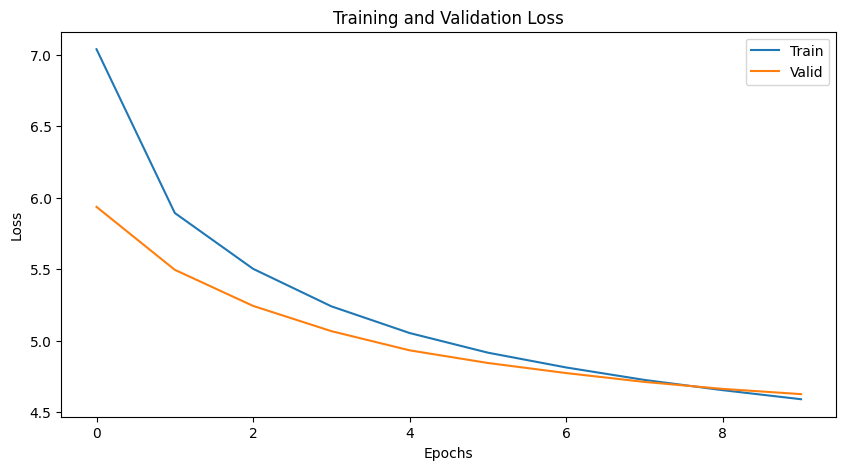

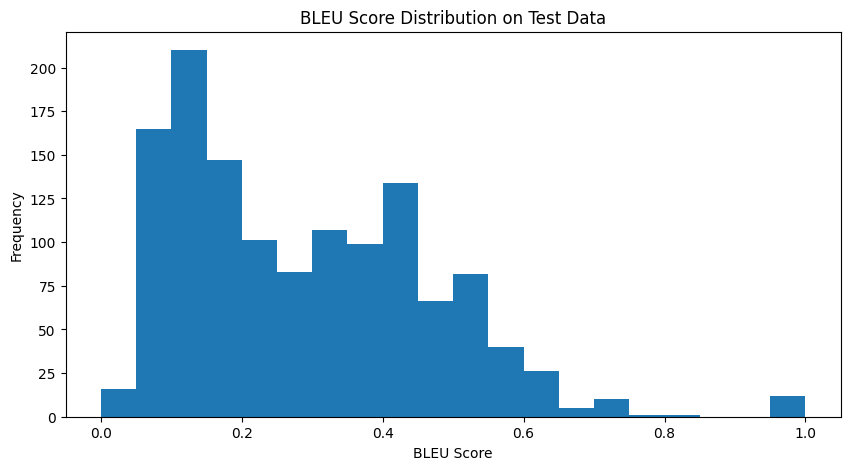

Average BLEU score on test data: 0.2886

Sample Translations:

Source (1): When I was in my 20s, I saw my very first psychotherapy client.
Target (1): Quand j'avais la vingtaine, j'ai vu mes tout premiers clients comme psychothérapeute.
Predicted (1): je suis allé , je suis allé , je suis allé , je suis allé de mon <UNK> . <EOS>

Source (2): I was a Ph.D. student in clinical psychology at Berkeley.
Target (2): J'étais étudiante en thèse en psychologie clinique à Berkeley.
Predicted (2): je suis un peu de la première fois . <EOS>

Source (3): She was a 26-year-old woman named Alex.
Target (3): Elle, c'était une femme de 26 ans appelée Alex.
Predicted (3): elle a été un <UNK> de <UNK> . <EOS>

Source (4): Now Alex walked into her first session wearing jeans and a big slouchy top, and she dropped onto the couch in my office and kicked off her flats and told me she was there to talk about guy problems.
Target (4): Lorsqu'Alex est entrée pour sa première séance, elle portait un jean et un g

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import random
import os
import time
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import nltk
import matplotlib.pyplot as plt

# Download punkt tokenizer for NLTK
nltk.download('punkt')

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Adjusted Hyperparameters for Reduced Memory Usage
NUM_EPOCHS = 10
BATCH_SIZE = 128           # Reduced batch size
LEARNING_RATE = 0.0001
EMBED_SIZE = 256          # Reduced embedding size
NUM_HEADS = 4             # Reduced number of heads
NUM_ENCODER_LAYERS = 3    # Reduced number of encoder layers
NUM_DECODER_LAYERS = 3    # Reduced number of decoder layers
FORWARD_EXPANSION = 2     # Reduced forward expansion
DROPOUT = 0.1
PAD_IDX = 0

# Limit maximum sequence length
MAX_LEN = 60             # Reduced maximum sequence length

# Paths to data
DATA_PATH = '/kaggle/input/datafiles/data'  # Update this path to your data directory

# Vocabulary class
class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v: k for k, v in self.itos.items()}

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer(text):
        return nltk.word_tokenize(text.lower())

    def build_vocabulary(self, sentences):
        frequencies = Counter()
        idx = 4

        for sentence in sentences:
            tokens = self.tokenizer(sentence)
            frequencies.update(tokens)

        for word, freq in frequencies.items():
            if freq >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer(text)
        return [
            self.stoi.get(token, self.stoi["<UNK>"]) for token in tokenized_text
        ]

# Custom Dataset
class TranslationDataset(Dataset):
    def __init__(self, src_sentences, trg_sentences, src_vocab, trg_vocab, max_len):
        self.src_sentences = src_sentences
        self.trg_sentences = trg_sentences
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.src_sentences)

    def __getitem__(self, idx):
        src_sentence = self.src_sentences[idx]
        trg_sentence = self.trg_sentences[idx]

        src_tensor = [self.src_vocab.stoi["<SOS>"]] + self.src_vocab.numericalize(src_sentence) + [self.src_vocab.stoi["<EOS>"]]
        trg_tensor = [self.trg_vocab.stoi["<SOS>"]] + self.trg_vocab.numericalize(trg_sentence) + [self.trg_vocab.stoi["<EOS>"]]

        # Truncate sequences longer than max_len
        src_tensor = src_tensor[:self.max_len]
        trg_tensor = trg_tensor[:self.max_len]

        return torch.tensor(src_tensor), torch.tensor(trg_tensor)

# Collate function for DataLoader
def collate_fn(batch):
    src_batch, trg_batch = [], []
    for src_sample, trg_sample in batch:
        src_batch.append(src_sample)
        trg_batch.append(trg_sample)

    src_batch = nn.utils.rnn.pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = nn.utils.rnn.pad_sequence(trg_batch, padding_value=PAD_IDX)

    return src_batch, trg_batch

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, max_len):
        super(PositionalEncoding, self).__init__()
        self.embed_size = embed_size

        pe = torch.zeros(max_len, embed_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-math.log(10000.0) / embed_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        if embed_size % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(0)
        x = x * math.sqrt(self.embed_size)
        if seq_len > self.pe.size(0):
            # Truncate positional encoding to match sequence length
            pe = self.pe[:seq_len, :]
        else:
            pe = self.pe[:seq_len, :]
        x = x + pe
        return x

# Scaled Dot-Product Attention (Modified)
class ScaledDotProductAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(ScaledDotProductAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embed size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys   = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries= nn.Linear(self.head_dim, self.head_dim, bias=False)

        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[1]
        value_len, key_len, query_len = values.shape[0], keys.shape[0], query.shape[0]

        # Split embedding into self.heads pieces
        values  = values.view(value_len, N, self.heads, self.head_dim)
        keys    = keys.view(key_len, N, self.heads, self.head_dim)
        queries = query.view(query_len, N, self.heads, self.head_dim)

        values  = self.values(values)
        keys    = self.keys(keys)
        queries = self.queries(queries)

        # Compute energy
        energy = torch.einsum("qnhd, knhd -> nhqk", [queries, keys])

        if mask is not None:
            # Adjust mask shape to match energy
            # mask shape: (N, 1, 1, key_len)
            # Expand mask to (N, 1, query_len, key_len)
            mask = mask.expand(-1, -1, query_len, key_len)
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        # Attention weights
        attention = torch.softmax(energy / math.sqrt(self.head_dim), dim=3)

        # Compute context vector
        out = torch.einsum("nhql, lnhd -> qnhd", [attention, values]).reshape(
            query_len, N, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = ScaledDotProductAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

# Encoder
class Encoder(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length,
    ):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = PositionalEncoding(embed_size, max_length)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        # x shape: (seq_length, N)
        N = x.shape[1]

        embeddings = self.dropout(
            self.position_embedding(self.word_embedding(x))
        )

        out = embeddings
        for layer in self.layers:
            out = layer(out, out, out, mask)

        return out

# Decoder Block
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()
        self.attention = ScaledDotProductAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(
            embed_size, heads, dropout, forward_expansion
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, src_mask, trg_mask):
        attention = self.attention(x, x, x, trg_mask)
        query = self.dropout(self.norm(attention + x))
        out = self.transformer_block(value, key, query, src_mask)
        return out

# Decoder
class Decoder(nn.Module):
    def __init__(
        self,
        trg_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        device,
        max_length,
    ):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = PositionalEncoding(embed_size, max_length)

        self.layers = nn.ModuleList(
            [
                DecoderBlock(
                    embed_size,
                    heads,
                    forward_expansion,
                    dropout,
                    device,
                )
                for _ in range(num_layers)
            ]
        )

        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, trg_mask):
        N = x.shape[1]
        embeddings = self.dropout(
            self.position_embedding(self.word_embedding(x))
        )

        out = embeddings
        for layer in self.layers:
            out = layer(out, enc_out, enc_out, src_mask, trg_mask)

        out = self.fc_out(out)
        return out

# Transformer
class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        trg_pad_idx,
        embed_size=EMBED_SIZE,
        num_layers=NUM_ENCODER_LAYERS,
        forward_expansion=FORWARD_EXPANSION,
        heads=NUM_HEADS,
        dropout=DROPOUT,
        device=device,
        max_length=MAX_LEN,
    ):
        super(Transformer, self).__init__()

        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length,
        )

        self.decoder = Decoder(
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            device,
            max_length,
        )

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        # src shape: (src_seq_len, N)
        src_mask = (src != self.src_pad_idx).transpose(0, 1).unsqueeze(1).unsqueeze(2)
        # src_mask shape: (N, 1, 1, src_seq_len)
        return src_mask.to(self.device)

    def make_trg_mask(self, trg):
        # trg shape: (trg_seq_len, N)
        N = trg.shape[1]
        trg_len = trg.shape[0]

        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).bool().to(self.device)
        trg_mask = trg_mask.expand(N, 1, trg_len, trg_len)

        # Padding mask
        padding_mask = (trg != self.trg_pad_idx).transpose(0,1).unsqueeze(1).unsqueeze(3)
        trg_mask = trg_mask & padding_mask

        return trg_mask.to(self.device)

    def forward(self, src, trg):
        # src shape: (src_seq_len, N)
        # trg shape: (trg_seq_len, N)
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        enc_src = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_src, src_mask, trg_mask)
        return out

# Training function
def train_model(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for i, (src, trg) in enumerate(iterator):
        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        output = model(src, trg[:-1, :])

        output_dim = output.shape[-1]

        output = output.view(-1, output_dim)
        trg = trg[1:].reshape(-1)

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

# Evaluation function
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, (src, trg) in enumerate(iterator):
            src = src.to(device)
            trg = trg.to(device)

            output = model(src, trg[:-1, :])
            output_dim = output.shape[-1]

            output = output.view(-1, output_dim)
            trg = trg[1:].reshape(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

# Translate a sentence
def translate_sentence(model, src_sentence, src_vocab, trg_vocab, max_length):
    model.eval()

    src_tensor = src_sentence.to(device)

    src_mask = model.make_src_mask(src_tensor)

    enc_src = model.encoder(src_tensor, src_mask)

    trg_indices = [trg_vocab.stoi["<SOS>"]]

    for i in range(max_length):
        trg_tensor = torch.LongTensor(trg_indices).unsqueeze(1).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)

        output = model.decoder(trg_tensor, enc_src, src_mask, trg_mask)
        pred_token = output.argmax(2)[-1, :].item()

        trg_indices.append(pred_token)

        if pred_token == trg_vocab.stoi["<EOS>"]:
            break

    trg_tokens = [trg_vocab.itos[i] for i in trg_indices]

    return trg_tokens[1:]  # Exclude the initial <SOS>

# Main function
def main():
    # Load data
    with open(os.path.join(DATA_PATH, 'train.en'), 'r', encoding='utf-8') as f:
        train_en = f.readlines()

    with open(os.path.join(DATA_PATH, 'train.fr'), 'r', encoding='utf-8') as f:
        train_fr = f.readlines()

    with open(os.path.join(DATA_PATH, 'dev.en'), 'r', encoding='utf-8') as f:
        dev_en = f.readlines()

    with open(os.path.join(DATA_PATH, 'dev.fr'), 'r', encoding='utf-8') as f:
        dev_fr = f.readlines()

    with open(os.path.join(DATA_PATH, 'test.en'), 'r', encoding='utf-8') as f:
        test_en = f.readlines()

    with open(os.path.join(DATA_PATH, 'test.fr'), 'r', encoding='utf-8') as f:
        test_fr = f.readlines()

    # Strip newline characters
    train_en = [line.strip() for line in train_en]
    train_fr = [line.strip() for line in train_fr]
    dev_en = [line.strip() for line in dev_en]
    dev_fr = [line.strip() for line in dev_fr]
    test_en = [line.strip() for line in test_en]
    test_fr = [line.strip() for line in test_fr]

    # Build vocabularies
    SRC_FREQ_THRESHOLD = 2
    TRG_FREQ_THRESHOLD = 2

    src_vocab = Vocabulary(SRC_FREQ_THRESHOLD)
    src_vocab.build_vocabulary(train_en)

    trg_vocab = Vocabulary(TRG_FREQ_THRESHOLD)
    trg_vocab.build_vocabulary(train_fr)

    # Create datasets
    train_dataset = TranslationDataset(train_en, train_fr, src_vocab, trg_vocab, MAX_LEN)
    dev_dataset = TranslationDataset(dev_en, dev_fr, src_vocab, trg_vocab, MAX_LEN)
    test_dataset = TranslationDataset(test_en, test_fr, src_vocab, trg_vocab, MAX_LEN)

    # Data loaders
    train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    dev_iterator = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    test_iterator = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

    # Initialize model
    SRC_VOCAB_SIZE = len(src_vocab)
    TRG_VOCAB_SIZE = len(trg_vocab)

    model = Transformer(
        SRC_VOCAB_SIZE,
        TRG_VOCAB_SIZE,
        src_vocab.stoi["<PAD>"],
        trg_vocab.stoi["<PAD>"],
        embed_size=EMBED_SIZE,
        num_layers=NUM_ENCODER_LAYERS,
        forward_expansion=FORWARD_EXPANSION,
        heads=NUM_HEADS,
        dropout=DROPOUT,
        device=device,
        max_length=MAX_LEN,
    ).to(device)

    # Optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

    # Lists to keep track of losses
    train_losses = []
    valid_losses = []

    # Training loop
    for epoch in range(NUM_EPOCHS):
        start_time = time.time()

        train_loss = train_model(model, train_iterator, optimizer, criterion, clip=1)
        valid_loss = evaluate(model, dev_iterator, criterion)

        end_time = time.time()

        epoch_mins, epoch_secs = divmod(int(end_time - start_time), 60)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f}')

    # Plotting the training and validation loss
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Loss")
    plt.plot(train_losses, label="Train")
    plt.plot(valid_losses, label="Valid")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig('loss_plot.png')
    plt.show()

    # Save the model
    torch.save(model.state_dict(), 'transformer.pt')

    # Testing and BLEU score
    model.eval()
    test_bleu_scores = []

    with open('testbleu.txt', 'w', encoding='utf-8') as f:
        for idx in range(len(test_dataset)):
            src, trg = test_dataset[idx]
            src = src.unsqueeze(1).to(device)
            trg = trg.to(device)

            # **Truncate the source sequence to MAX_LEN to prevent positional encoding mismatch**
            src_numericalized = src_vocab.numericalize(test_en[idx])
            src_numericalized = src_numericalized[:MAX_LEN - 2]  # Reserve space for <SOS> and <EOS>
            src_tensor = torch.tensor([src_vocab.stoi["<SOS>"]] + src_numericalized + [src_vocab.stoi["<EOS>"]]).unsqueeze(1).to(device)

            predicted_trg = translate_sentence(model, src_tensor, src_vocab, trg_vocab, MAX_LEN)
            reference = [trg_vocab.itos[token] for token in trg.cpu().numpy()]
            reference = reference[1:-1]  # Exclude <SOS> and <EOS>
            predicted_trg = predicted_trg[:-1]  # Exclude <EOS>

            score = sentence_bleu([reference], predicted_trg, weights=(0.5, 0.5))
            test_bleu_scores.append(score)
            f.write(' '.join(predicted_trg) + f' {score}\n')

    # Plot BLEU score distribution
    plt.figure(figsize=(10,5))
    plt.title("BLEU Score Distribution on Test Data")
    plt.hist(test_bleu_scores, bins=20)
    plt.xlabel("BLEU Score")
    plt.ylabel("Frequency")
    plt.savefig('bleu_distribution.png')
    plt.show()

    print(f'Average BLEU score on test data: {np.mean(test_bleu_scores):.4f}')

    # Sample translations
    num_samples = 5
    print("\nSample Translations:")
    for i in range(num_samples):
        src_sentence = test_en[i]
        trg_sentence = test_fr[i]
        
        # **Truncate the source sequence to MAX_LEN - 2 to prevent positional encoding mismatch**
        src_numericalized = src_vocab.numericalize(src_sentence)
        src_numericalized = src_numericalized[:MAX_LEN - 2]  # Reserve space for <SOS> and <EOS>
        src_tensor = torch.tensor([src_vocab.stoi["<SOS>"]] + src_numericalized + [src_vocab.stoi["<EOS>"]]).unsqueeze(1).to(device)
        
        predicted_trg = translate_sentence(model, src_tensor, src_vocab, trg_vocab, MAX_LEN)
        reference = trg_sentence.split()
        reference = reference[:MAX_LEN - 2]  # Truncate reference if necessary

        print(f"\nSource ({i+1}): {src_sentence}")
        print(f"Target ({i+1}): {trg_sentence}")
        print(f"Predicted ({i+1}): {' '.join(predicted_trg)}")

if __name__ == '__main__':
    main()


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Epoch: 01 | Time: 0m 41s
	Train Loss: 7.038
	 Val. Loss: 5.936
Epoch: 02 | Time: 0m 43s
	Train Loss: 5.893
	 Val. Loss: 5.496
Epoch: 03 | Time: 0m 43s
	Train Loss: 5.503
	 Val. Loss: 5.244
Epoch: 04 | Time: 0m 42s
	Train Loss: 5.241
	 Val. Loss: 5.068
Epoch: 05 | Time: 0m 41s
	Train Loss: 5.054
	 Val. Loss: 4.933
Epoch: 06 | Time: 0m 42s
	Train Loss: 4.917
	 Val. Loss: 4.845
Epoch: 07 | Time: 0m 42s
	Train Loss: 4.814
	 Val. Loss: 4.775
Epoch: 08 | Time: 0m 42s
	Train Loss: 4.727
	 Val. Loss: 4.713
Epoch: 09 | Time: 0m 42s
	Train Loss: 4.655
	 Val. Loss: 4.664
Epoch: 10 | Time: 0m 41s
	Train Loss: 4.592
	 Val. Loss: 4.627
Epoch: 11 | Time: 0m 42s
	Train Loss: 4.535
	 Val. Loss: 4.575
Epoch: 12 | Time: 0m 43s
	Train Loss: 4.485
	 Val. Loss: 4.548
Epoch: 13 | Time: 0m 42s
	Train Loss: 4.437
	 Val. Loss: 4.525
Epoch: 14 | Time: 0m 42s
	Train Loss: 4.391
	 Val. Loss: 4.486
Ep

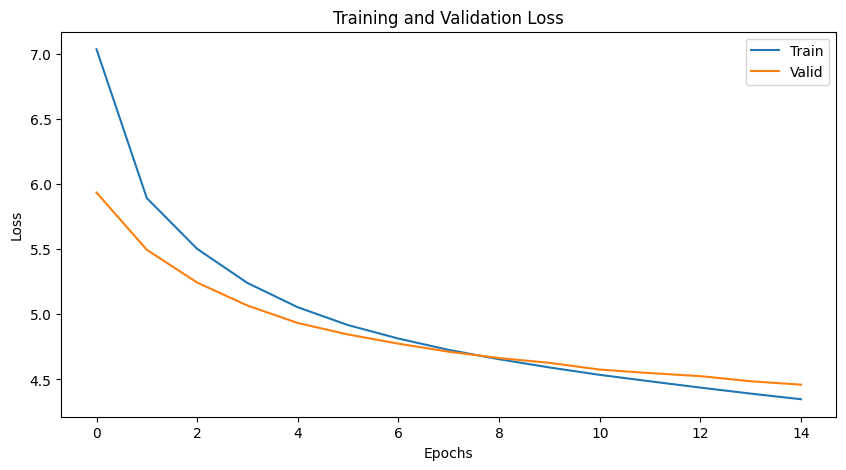

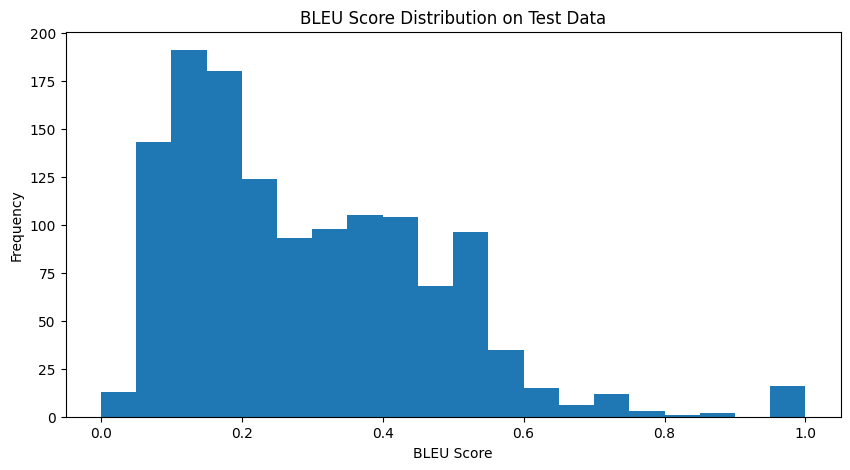

Average BLEU score on test data: 0.2918

Sample Translations:

Source (1): When I was in my 20s, I saw my very first psychotherapy client.
Target (1): Quand j'avais la vingtaine, j'ai vu mes tout premiers clients comme psychothérapeute.
Predicted (1): je suis allé , je suis allé , je suis allé à mon <UNK> . <EOS>

Source (2): I was a Ph.D. student in clinical psychology at Berkeley.
Target (2): J'étais étudiante en thèse en psychologie clinique à Berkeley.
Predicted (2): je suis un <UNK> dans un <UNK> . <EOS>

Source (3): She was a 26-year-old woman named Alex.
Target (3): Elle, c'était une femme de 26 ans appelée Alex.
Predicted (3): elle était un <UNK> <UNK> . <EOS>

Source (4): Now Alex walked into her first session wearing jeans and a big slouchy top, and she dropped onto the couch in my office and kicked off her flats and told me she was there to talk about guy problems.
Target (4): Lorsqu'Alex est entrée pour sa première séance, elle portait un jean et un grand top trop large, el

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import random
import os
import time
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import nltk
import matplotlib.pyplot as plt

# Download punkt tokenizer for NLTK
nltk.download('punkt')

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Adjusted Hyperparameters for Reduced Memory Usage
NUM_EPOCHS = 15
BATCH_SIZE = 128           # Reduced batch size
LEARNING_RATE = 0.0001
EMBED_SIZE = 256          # Reduced embedding size
NUM_HEADS = 4             # Reduced number of heads
NUM_ENCODER_LAYERS = 3    # Reduced number of encoder layers
NUM_DECODER_LAYERS = 3    # Reduced number of decoder layers
FORWARD_EXPANSION = 2     # Reduced forward expansion
DROPOUT = 0.1
PAD_IDX = 0

# Limit maximum sequence length
MAX_LEN = 60             # Reduced maximum sequence length

# Paths to data
DATA_PATH = '/kaggle/input/datafiles/data'  # Update this path to your data directory

# Vocabulary class
class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v: k for k, v in self.itos.items()}

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer(text):
        return nltk.word_tokenize(text.lower())

    def build_vocabulary(self, sentences):
        frequencies = Counter()
        idx = 4

        for sentence in sentences:
            tokens = self.tokenizer(sentence)
            frequencies.update(tokens)

        for word, freq in frequencies.items():
            if freq >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer(text)
        return [
            self.stoi.get(token, self.stoi["<UNK>"]) for token in tokenized_text
        ]

# Custom Dataset
class TranslationDataset(Dataset):
    def __init__(self, src_sentences, trg_sentences, src_vocab, trg_vocab, max_len):
        self.src_sentences = src_sentences
        self.trg_sentences = trg_sentences
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.src_sentences)

    def __getitem__(self, idx):
        src_sentence = self.src_sentences[idx]
        trg_sentence = self.trg_sentences[idx]

        src_tensor = [self.src_vocab.stoi["<SOS>"]] + self.src_vocab.numericalize(src_sentence) + [self.src_vocab.stoi["<EOS>"]]
        trg_tensor = [self.trg_vocab.stoi["<SOS>"]] + self.trg_vocab.numericalize(trg_sentence) + [self.trg_vocab.stoi["<EOS>"]]

        # Truncate sequences longer than max_len
        src_tensor = src_tensor[:self.max_len]
        trg_tensor = trg_tensor[:self.max_len]

        return torch.tensor(src_tensor), torch.tensor(trg_tensor)

# Collate function for DataLoader
def collate_fn(batch):
    src_batch, trg_batch = [], []
    for src_sample, trg_sample in batch:
        src_batch.append(src_sample)
        trg_batch.append(trg_sample)

    src_batch = nn.utils.rnn.pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = nn.utils.rnn.pad_sequence(trg_batch, padding_value=PAD_IDX)

    return src_batch, trg_batch

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, max_len):
        super(PositionalEncoding, self).__init__()
        self.embed_size = embed_size

        pe = torch.zeros(max_len, embed_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-math.log(10000.0) / embed_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        if embed_size % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(0)
        x = x * math.sqrt(self.embed_size)
        if seq_len > self.pe.size(0):
            # Truncate positional encoding to match sequence length
            pe = self.pe[:seq_len, :]
        else:
            pe = self.pe[:seq_len, :]
        x = x + pe
        return x

# Scaled Dot-Product Attention (Modified)
class ScaledDotProductAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(ScaledDotProductAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embed size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys   = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries= nn.Linear(self.head_dim, self.head_dim, bias=False)

        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[1]
        value_len, key_len, query_len = values.shape[0], keys.shape[0], query.shape[0]

        # Split embedding into self.heads pieces
        values  = values.view(value_len, N, self.heads, self.head_dim)
        keys    = keys.view(key_len, N, self.heads, self.head_dim)
        queries = query.view(query_len, N, self.heads, self.head_dim)

        values  = self.values(values)
        keys    = self.keys(keys)
        queries = self.queries(queries)

        # Compute energy
        energy = torch.einsum("qnhd, knhd -> nhqk", [queries, keys])

        if mask is not None:
            # Adjust mask shape to match energy
            # mask shape: (N, 1, 1, key_len)
            # Expand mask to (N, 1, query_len, key_len)
            mask = mask.expand(-1, -1, query_len, key_len)
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        # Attention weights
        attention = torch.softmax(energy / math.sqrt(self.head_dim), dim=3)

        # Compute context vector
        out = torch.einsum("nhql, lnhd -> qnhd", [attention, values]).reshape(
            query_len, N, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = ScaledDotProductAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

# Encoder
class Encoder(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length,
    ):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = PositionalEncoding(embed_size, max_length)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        # x shape: (seq_length, N)
        N = x.shape[1]

        embeddings = self.dropout(
            self.position_embedding(self.word_embedding(x))
        )

        out = embeddings
        for layer in self.layers:
            out = layer(out, out, out, mask)

        return out

# Decoder Block
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()
        self.attention = ScaledDotProductAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(
            embed_size, heads, dropout, forward_expansion
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, src_mask, trg_mask):
        attention = self.attention(x, x, x, trg_mask)
        query = self.dropout(self.norm(attention + x))
        out = self.transformer_block(value, key, query, src_mask)
        return out

# Decoder
class Decoder(nn.Module):
    def __init__(
        self,
        trg_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        device,
        max_length,
    ):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = PositionalEncoding(embed_size, max_length)

        self.layers = nn.ModuleList(
            [
                DecoderBlock(
                    embed_size,
                    heads,
                    forward_expansion,
                    dropout,
                    device,
                )
                for _ in range(num_layers)
            ]
        )

        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, trg_mask):
        N = x.shape[1]
        embeddings = self.dropout(
            self.position_embedding(self.word_embedding(x))
        )

        out = embeddings
        for layer in self.layers:
            out = layer(out, enc_out, enc_out, src_mask, trg_mask)

        out = self.fc_out(out)
        return out

# Transformer
class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        trg_pad_idx,
        embed_size=EMBED_SIZE,
        num_layers=NUM_ENCODER_LAYERS,
        forward_expansion=FORWARD_EXPANSION,
        heads=NUM_HEADS,
        dropout=DROPOUT,
        device=device,
        max_length=MAX_LEN,
    ):
        super(Transformer, self).__init__()

        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length,
        )

        self.decoder = Decoder(
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            device,
            max_length,
        )

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        # src shape: (src_seq_len, N)
        src_mask = (src != self.src_pad_idx).transpose(0, 1).unsqueeze(1).unsqueeze(2)
        # src_mask shape: (N, 1, 1, src_seq_len)
        return src_mask.to(self.device)

    def make_trg_mask(self, trg):
        # trg shape: (trg_seq_len, N)
        N = trg.shape[1]
        trg_len = trg.shape[0]

        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).bool().to(self.device)
        trg_mask = trg_mask.expand(N, 1, trg_len, trg_len)

        # Padding mask
        padding_mask = (trg != self.trg_pad_idx).transpose(0,1).unsqueeze(1).unsqueeze(3)
        trg_mask = trg_mask & padding_mask

        return trg_mask.to(self.device)

    def forward(self, src, trg):
        # src shape: (src_seq_len, N)
        # trg shape: (trg_seq_len, N)
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        enc_src = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_src, src_mask, trg_mask)
        return out

# Training function
def train_model(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for i, (src, trg) in enumerate(iterator):
        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        output = model(src, trg[:-1, :])

        output_dim = output.shape[-1]

        output = output.view(-1, output_dim)
        trg = trg[1:].reshape(-1)

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

# Evaluation function
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, (src, trg) in enumerate(iterator):
            src = src.to(device)
            trg = trg.to(device)

            output = model(src, trg[:-1, :])
            output_dim = output.shape[-1]

            output = output.view(-1, output_dim)
            trg = trg[1:].reshape(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

# Translate a sentence
def translate_sentence(model, src_sentence, src_vocab, trg_vocab, max_length):
    model.eval()

    src_tensor = src_sentence.to(device)

    src_mask = model.make_src_mask(src_tensor)

    enc_src = model.encoder(src_tensor, src_mask)

    trg_indices = [trg_vocab.stoi["<SOS>"]]

    for i in range(max_length):
        trg_tensor = torch.LongTensor(trg_indices).unsqueeze(1).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)

        output = model.decoder(trg_tensor, enc_src, src_mask, trg_mask)
        pred_token = output.argmax(2)[-1, :].item()

        trg_indices.append(pred_token)

        if pred_token == trg_vocab.stoi["<EOS>"]:
            break

    trg_tokens = [trg_vocab.itos[i] for i in trg_indices]

    return trg_tokens[1:]  # Exclude the initial <SOS>

# Main function
def main():
    # Load data
    with open(os.path.join(DATA_PATH, 'train.en'), 'r', encoding='utf-8') as f:
        train_en = f.readlines()

    with open(os.path.join(DATA_PATH, 'train.fr'), 'r', encoding='utf-8') as f:
        train_fr = f.readlines()

    with open(os.path.join(DATA_PATH, 'dev.en'), 'r', encoding='utf-8') as f:
        dev_en = f.readlines()

    with open(os.path.join(DATA_PATH, 'dev.fr'), 'r', encoding='utf-8') as f:
        dev_fr = f.readlines()

    with open(os.path.join(DATA_PATH, 'test.en'), 'r', encoding='utf-8') as f:
        test_en = f.readlines()

    with open(os.path.join(DATA_PATH, 'test.fr'), 'r', encoding='utf-8') as f:
        test_fr = f.readlines()

    # Strip newline characters
    train_en = [line.strip() for line in train_en]
    train_fr = [line.strip() for line in train_fr]
    dev_en = [line.strip() for line in dev_en]
    dev_fr = [line.strip() for line in dev_fr]
    test_en = [line.strip() for line in test_en]
    test_fr = [line.strip() for line in test_fr]

    # Build vocabularies
    SRC_FREQ_THRESHOLD = 2
    TRG_FREQ_THRESHOLD = 2

    src_vocab = Vocabulary(SRC_FREQ_THRESHOLD)
    src_vocab.build_vocabulary(train_en)

    trg_vocab = Vocabulary(TRG_FREQ_THRESHOLD)
    trg_vocab.build_vocabulary(train_fr)

    # Create datasets
    train_dataset = TranslationDataset(train_en, train_fr, src_vocab, trg_vocab, MAX_LEN)
    dev_dataset = TranslationDataset(dev_en, dev_fr, src_vocab, trg_vocab, MAX_LEN)
    test_dataset = TranslationDataset(test_en, test_fr, src_vocab, trg_vocab, MAX_LEN)

    # Data loaders
    train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    dev_iterator = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    test_iterator = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

    # Initialize model
    SRC_VOCAB_SIZE = len(src_vocab)
    TRG_VOCAB_SIZE = len(trg_vocab)

    model = Transformer(
        SRC_VOCAB_SIZE,
        TRG_VOCAB_SIZE,
        src_vocab.stoi["<PAD>"],
        trg_vocab.stoi["<PAD>"],
        embed_size=EMBED_SIZE,
        num_layers=NUM_ENCODER_LAYERS,
        forward_expansion=FORWARD_EXPANSION,
        heads=NUM_HEADS,
        dropout=DROPOUT,
        device=device,
        max_length=MAX_LEN,
    ).to(device)

    # Optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

    # Lists to keep track of losses
    train_losses = []
    valid_losses = []

    # Training loop
    for epoch in range(NUM_EPOCHS):
        start_time = time.time()

        train_loss = train_model(model, train_iterator, optimizer, criterion, clip=1)
        valid_loss = evaluate(model, dev_iterator, criterion)

        end_time = time.time()

        epoch_mins, epoch_secs = divmod(int(end_time - start_time), 60)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f}')

    # Plotting the training and validation loss
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Loss")
    plt.plot(train_losses, label="Train")
    plt.plot(valid_losses, label="Valid")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig('loss_plot.png')
    plt.show()

    # Save the model
    torch.save(model.state_dict(), 'transformer.pt')

    # Testing and BLEU score
    model.eval()
    test_bleu_scores = []

    with open('testbleu.txt', 'w', encoding='utf-8') as f:
        for idx in range(len(test_dataset)):
            src, trg = test_dataset[idx]
            src = src.unsqueeze(1).to(device)
            trg = trg.to(device)

            # **Truncate the source sequence to MAX_LEN to prevent positional encoding mismatch**
            src_numericalized = src_vocab.numericalize(test_en[idx])
            src_numericalized = src_numericalized[:MAX_LEN - 2]  # Reserve space for <SOS> and <EOS>
            src_tensor = torch.tensor([src_vocab.stoi["<SOS>"]] + src_numericalized + [src_vocab.stoi["<EOS>"]]).unsqueeze(1).to(device)

            predicted_trg = translate_sentence(model, src_tensor, src_vocab, trg_vocab, MAX_LEN)
            reference = [trg_vocab.itos[token] for token in trg.cpu().numpy()]
            reference = reference[1:-1]  # Exclude <SOS> and <EOS>
            predicted_trg = predicted_trg[:-1]  # Exclude <EOS>

            score = sentence_bleu([reference], predicted_trg, weights=(0.5, 0.5))
            test_bleu_scores.append(score)
            f.write(' '.join(predicted_trg) + f' {score}\n')

    # Plot BLEU score distribution
    plt.figure(figsize=(10,5))
    plt.title("BLEU Score Distribution on Test Data")
    plt.hist(test_bleu_scores, bins=20)
    plt.xlabel("BLEU Score")
    plt.ylabel("Frequency")
    plt.savefig('bleu_distribution.png')
    plt.show()

    print(f'Average BLEU score on test data: {np.mean(test_bleu_scores):.4f}')

    # Sample translations
    num_samples = 5
    print("\nSample Translations:")
    for i in range(num_samples):
        src_sentence = test_en[i]
        trg_sentence = test_fr[i]
        
        # **Truncate the source sequence to MAX_LEN - 2 to prevent positional encoding mismatch**
        src_numericalized = src_vocab.numericalize(src_sentence)
        src_numericalized = src_numericalized[:MAX_LEN - 2]  # Reserve space for <SOS> and <EOS>
        src_tensor = torch.tensor([src_vocab.stoi["<SOS>"]] + src_numericalized + [src_vocab.stoi["<EOS>"]]).unsqueeze(1).to(device)
        
        predicted_trg = translate_sentence(model, src_tensor, src_vocab, trg_vocab, MAX_LEN)
        reference = trg_sentence.split()
        reference = reference[:MAX_LEN - 2]  # Truncate reference if necessary

        print(f"\nSource ({i+1}): {src_sentence}")
        print(f"Target ({i+1}): {trg_sentence}")
        print(f"Predicted ({i+1}): {' '.join(predicted_trg)}")

if __name__ == '__main__':
    main()


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Epoch: 01 | Time: 0m 42s
	Train Loss: 7.038
	 Val. Loss: 5.936
Epoch: 02 | Time: 0m 42s
	Train Loss: 5.893
	 Val. Loss: 5.496
Epoch: 03 | Time: 0m 42s
	Train Loss: 5.503
	 Val. Loss: 5.244
Epoch: 04 | Time: 0m 42s
	Train Loss: 5.241
	 Val. Loss: 5.066
Epoch: 05 | Time: 0m 42s
	Train Loss: 5.054
	 Val. Loss: 4.932
Epoch: 06 | Time: 0m 42s
	Train Loss: 4.917
	 Val. Loss: 4.844
Epoch: 07 | Time: 0m 42s
	Train Loss: 4.814
	 Val. Loss: 4.773
Epoch: 08 | Time: 0m 43s
	Train Loss: 4.727
	 Val. Loss: 4.712
Epoch: 09 | Time: 0m 42s
	Train Loss: 4.655
	 Val. Loss: 4.664
Epoch: 10 | Time: 0m 42s
	Train Loss: 4.592
	 Val. Loss: 4.627
Epoch: 11 | Time: 0m 42s
	Train Loss: 4.535
	 Val. Loss: 4.575
Epoch: 12 | Time: 0m 42s
	Train Loss: 4.485
	 Val. Loss: 4.548
Epoch: 13 | Time: 0m 42s
	Train Loss: 4.437
	 Val. Loss: 4.525
Epoch: 14 | Time: 0m 42s
	Train Loss: 4.391
	 Val. Loss: 4.486
Ep

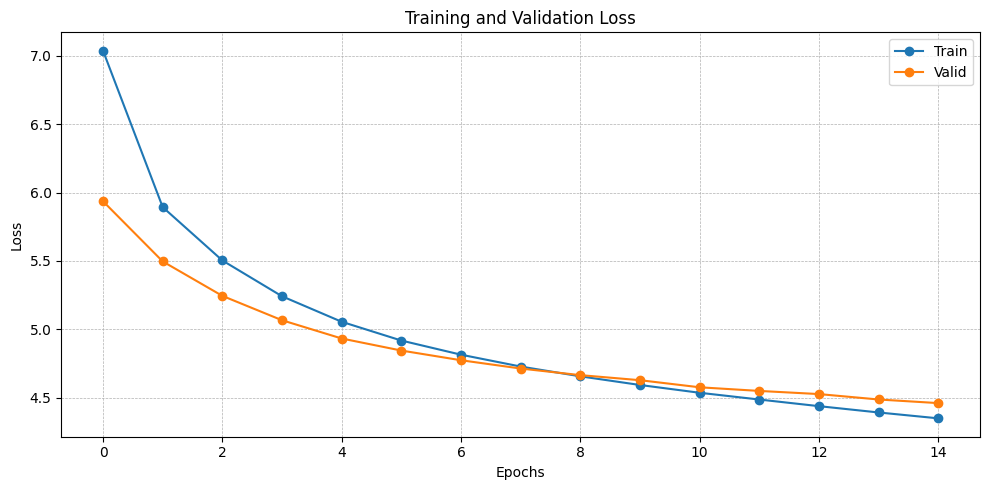

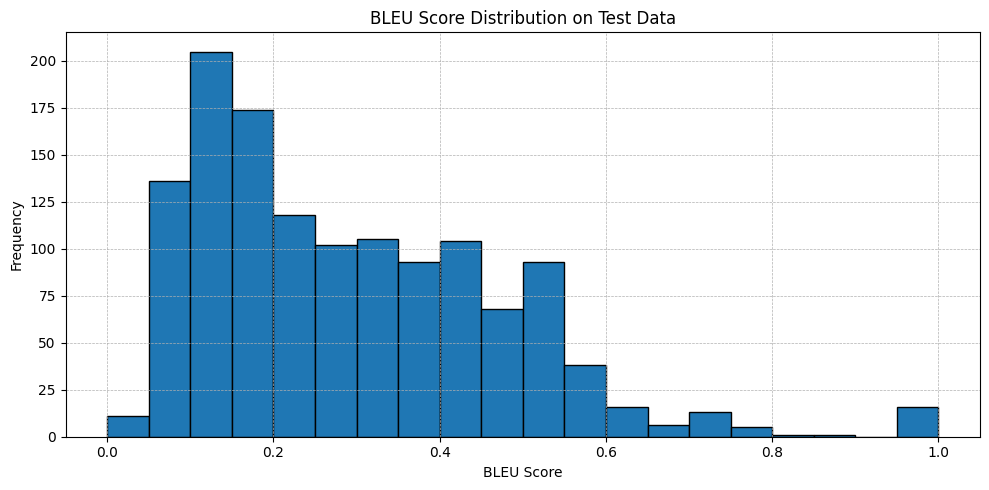

Average BLEU score on test data: 0.2922

Sample Translations:
Sample     Source                                             Target                                             Predicted                                          BLEU      
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1          When I was in my 20s, I saw my very first psychoth... Quand j'avais la vingtaine, j'ai vu mes tout premi... je suis allé , je suis allé , je suis allé à mon <... 0.0000    
2          I was a Ph.D. student in clinical psychology at Be... J'étais étudiante en thèse en psychologie clinique... je suis un <UNK> dans un <UNK> . <EOS>             0.0000    
3          She was a 26-year-old woman named Alex.            Elle, c'était une femme de 26 ans appelée Alex.    elle était un <UNK> <UNK> . <EOS>                  0.0000    
4          Now Alex walked into her first session we

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import random
import os
import time
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import nltk
import matplotlib.pyplot as plt

# Download punkt tokenizer for NLTK
nltk.download('punkt')

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Adjusted Hyperparameters for Reduced Memory Usage
NUM_EPOCHS = 15
BATCH_SIZE = 128           # Reduced batch size
LEARNING_RATE = 0.0001
EMBED_SIZE = 256          # Reduced embedding size
NUM_HEADS = 4             # Reduced number of heads
NUM_ENCODER_LAYERS = 3    # Reduced number of encoder layers
NUM_DECODER_LAYERS = 3    # Reduced number of decoder layers
FORWARD_EXPANSION = 2     # Reduced forward expansion
DROPOUT = 0.1
PAD_IDX = 0

# Limit maximum sequence length
MAX_LEN = 60             # Reduced maximum sequence length

# Paths to data
DATA_PATH = '/kaggle/input/datafiles/data'  # Update this path to your data directory

# Vocabulary class
class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v: k for k, v in self.itos.items()}

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer(text):
        return nltk.word_tokenize(text.lower())

    def build_vocabulary(self, sentences):
        frequencies = Counter()
        idx = 4

        for sentence in sentences:
            tokens = self.tokenizer(sentence)
            frequencies.update(tokens)

        for word, freq in frequencies.items():
            if freq >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer(text)
        return [
            self.stoi.get(token, self.stoi["<UNK>"]) for token in tokenized_text
        ]

# Custom Dataset
class TranslationDataset(Dataset):
    def __init__(self, src_sentences, trg_sentences, src_vocab, trg_vocab, max_len):
        self.src_sentences = src_sentences
        self.trg_sentences = trg_sentences
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.src_sentences)

    def __getitem__(self, idx):
        src_sentence = self.src_sentences[idx]
        trg_sentence = self.trg_sentences[idx]

        src_tensor = [self.src_vocab.stoi["<SOS>"]] + self.src_vocab.numericalize(src_sentence) + [self.src_vocab.stoi["<EOS>"]]
        trg_tensor = [self.trg_vocab.stoi["<SOS>"]] + self.trg_vocab.numericalize(trg_sentence) + [self.trg_vocab.stoi["<EOS>"]]

        # Truncate sequences longer than max_len
        src_tensor = src_tensor[:self.max_len]
        trg_tensor = trg_tensor[:self.max_len]

        return torch.tensor(src_tensor), torch.tensor(trg_tensor)

# Collate function for DataLoader
def collate_fn(batch):
    src_batch, trg_batch = [], []
    for src_sample, trg_sample in batch:
        src_batch.append(src_sample)
        trg_batch.append(trg_sample)

    src_batch = nn.utils.rnn.pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = nn.utils.rnn.pad_sequence(trg_batch, padding_value=PAD_IDX)

    return src_batch, trg_batch

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, max_len):
        super(PositionalEncoding, self).__init__()
        self.embed_size = embed_size

        pe = torch.zeros(max_len, embed_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-math.log(10000.0) / embed_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        if embed_size % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(0)
        x = x * math.sqrt(self.embed_size)
        if seq_len > self.pe.size(0):
            # Truncate positional encoding to match sequence length
            pe = self.pe[:seq_len, :]
        else:
            pe = self.pe[:seq_len, :]
        x = x + pe
        return x

# Scaled Dot-Product Attention (Modified)
class ScaledDotProductAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(ScaledDotProductAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embed size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys   = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries= nn.Linear(self.head_dim, self.head_dim, bias=False)

        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[1]
        value_len, key_len, query_len = values.shape[0], keys.shape[0], query.shape[0]

        # Split embedding into self.heads pieces
        values  = values.view(value_len, N, self.heads, self.head_dim)
        keys    = keys.view(key_len, N, self.heads, self.head_dim)
        queries = query.view(query_len, N, self.heads, self.head_dim)

        values  = self.values(values)
        keys    = self.keys(keys)
        queries = self.queries(queries)

        # Compute energy
        energy = torch.einsum("qnhd, knhd -> nhqk", [queries, keys])

        if mask is not None:
            # Adjust mask shape to match energy
            # mask shape: (N, 1, 1, key_len)
            # Expand mask to (N, 1, query_len, key_len)
            mask = mask.expand(-1, -1, query_len, key_len)
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        # Attention weights
        attention = torch.softmax(energy / math.sqrt(self.head_dim), dim=3)

        # Compute context vector
        out = torch.einsum("nhql, lnhd -> qnhd", [attention, values]).reshape(
            query_len, N, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = ScaledDotProductAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

# Encoder
class Encoder(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length,
    ):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = PositionalEncoding(embed_size, max_length)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        # x shape: (seq_length, N)
        N = x.shape[1]

        embeddings = self.dropout(
            self.position_embedding(self.word_embedding(x))
        )

        out = embeddings
        for layer in self.layers:
            out = layer(out, out, out, mask)

        return out

# Decoder Block
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()
        self.attention = ScaledDotProductAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(
            embed_size, heads, dropout, forward_expansion
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, src_mask, trg_mask):
        attention = self.attention(x, x, x, trg_mask)
        query = self.dropout(self.norm(attention + x))
        out = self.transformer_block(value, key, query, src_mask)
        return out

# Decoder
class Decoder(nn.Module):
    def __init__(
        self,
        trg_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        device,
        max_length,
    ):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = PositionalEncoding(embed_size, max_length)

        self.layers = nn.ModuleList(
            [
                DecoderBlock(
                    embed_size,
                    heads,
                    forward_expansion,
                    dropout,
                    device,
                )
                for _ in range(num_layers)
            ]
        )

        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, trg_mask):
        # x shape: (trg_seq_len, N)
        N = x.shape[1]
        embeddings = self.dropout(
            self.position_embedding(self.word_embedding(x))
        )

        out = embeddings
        for layer in self.layers:
            out = layer(out, enc_out, enc_out, src_mask, trg_mask)

        out = self.fc_out(out)
        return out

# Transformer
class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        trg_pad_idx,
        embed_size=EMBED_SIZE,
        num_layers=NUM_ENCODER_LAYERS,
        forward_expansion=FORWARD_EXPANSION,
        heads=NUM_HEADS,
        dropout=DROPOUT,
        device=device,
        max_length=MAX_LEN,
    ):
        super(Transformer, self).__init__()

        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length,
        )

        self.decoder = Decoder(
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            device,
            max_length,
        )

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        # src shape: (src_seq_len, N)
        src_mask = (src != self.src_pad_idx).transpose(0, 1).unsqueeze(1).unsqueeze(2)
        # src_mask shape: (N, 1, 1, src_seq_len)
        return src_mask.to(self.device)

    def make_trg_mask(self, trg):
        # trg shape: (trg_seq_len, N)
        N = trg.shape[1]
        trg_len = trg.shape[0]

        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).bool().to(self.device)
        trg_mask = trg_mask.expand(N, 1, trg_len, trg_len)

        # Padding mask
        padding_mask = (trg != self.trg_pad_idx).transpose(0,1).unsqueeze(1).unsqueeze(3)
        trg_mask = trg_mask & padding_mask

        return trg_mask.to(self.device)

    def forward(self, src, trg):
        # src shape: (src_seq_len, N)
        # trg shape: (trg_seq_len, N)
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        enc_src = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_src, src_mask, trg_mask)
        return out

# Training function
def train_model(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for i, (src, trg) in enumerate(iterator):
        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        output = model(src, trg[:-1, :])

        output_dim = output.shape[-1]

        output = output.view(-1, output_dim)
        trg = trg[1:].reshape(-1)

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

# Evaluation function
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, (src, trg) in enumerate(iterator):
            src = src.to(device)
            trg = trg.to(device)

            output = model(src, trg[:-1, :])
            output_dim = output.shape[-1]

            output = output.view(-1, output_dim)
            trg = trg[1:].reshape(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

# Translate a sentence
def translate_sentence(model, src_sentence, src_vocab, trg_vocab, max_length):
    model.eval()

    src_tensor = src_sentence.to(device)

    src_mask = model.make_src_mask(src_tensor)

    enc_src = model.encoder(src_tensor, src_mask)

    trg_indices = [trg_vocab.stoi["<SOS>"]]

    for i in range(max_length):
        trg_tensor = torch.LongTensor(trg_indices).unsqueeze(1).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)

        output = model.decoder(trg_tensor, enc_src, src_mask, trg_mask)
        pred_token = output.argmax(2)[-1, :].item()

        trg_indices.append(pred_token)

        if pred_token == trg_vocab.stoi["<EOS>"]:
            break

    trg_tokens = [trg_vocab.itos[i] for i in trg_indices]

    return trg_tokens[1:]  # Exclude the initial <SOS>

# Main function
def main():
    # Load data
    with open(os.path.join(DATA_PATH, 'train.en'), 'r', encoding='utf-8') as f:
        train_en = f.readlines()

    with open(os.path.join(DATA_PATH, 'train.fr'), 'r', encoding='utf-8') as f:
        train_fr = f.readlines()

    with open(os.path.join(DATA_PATH, 'dev.en'), 'r', encoding='utf-8') as f:
        dev_en = f.readlines()

    with open(os.path.join(DATA_PATH, 'dev.fr'), 'r', encoding='utf-8') as f:
        dev_fr = f.readlines()

    with open(os.path.join(DATA_PATH, 'test.en'), 'r', encoding='utf-8') as f:
        test_en = f.readlines()

    with open(os.path.join(DATA_PATH, 'test.fr'), 'r', encoding='utf-8') as f:
        test_fr = f.readlines()

    # Strip newline characters
    train_en = [line.strip() for line in train_en]
    train_fr = [line.strip() for line in train_fr]
    dev_en = [line.strip() for line in dev_en]
    dev_fr = [line.strip() for line in dev_fr]
    test_en = [line.strip() for line in test_en]
    test_fr = [line.strip() for line in test_fr]

    # Build vocabularies
    SRC_FREQ_THRESHOLD = 2
    TRG_FREQ_THRESHOLD = 2

    src_vocab = Vocabulary(SRC_FREQ_THRESHOLD)
    src_vocab.build_vocabulary(train_en)

    trg_vocab = Vocabulary(TRG_FREQ_THRESHOLD)
    trg_vocab.build_vocabulary(train_fr)

    # Create datasets
    train_dataset = TranslationDataset(train_en, train_fr, src_vocab, trg_vocab, MAX_LEN)
    dev_dataset = TranslationDataset(dev_en, dev_fr, src_vocab, trg_vocab, MAX_LEN)
    test_dataset = TranslationDataset(test_en, test_fr, src_vocab, trg_vocab, MAX_LEN)

    # Data loaders
    train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    dev_iterator = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    test_iterator = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

    # Initialize model
    SRC_VOCAB_SIZE = len(src_vocab)
    TRG_VOCAB_SIZE = len(trg_vocab)

    model = Transformer(
        SRC_VOCAB_SIZE,
        TRG_VOCAB_SIZE,
        src_vocab.stoi["<PAD>"],
        trg_vocab.stoi["<PAD>"],
        embed_size=EMBED_SIZE,
        num_layers=NUM_ENCODER_LAYERS,
        forward_expansion=FORWARD_EXPANSION,
        heads=NUM_HEADS,
        dropout=DROPOUT,
        device=device,
        max_length=MAX_LEN,
    ).to(device)

    # Optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

    # Lists to keep track of losses
    train_losses = []
    valid_losses = []

    # Training loop
    for epoch in range(NUM_EPOCHS):
        start_time = time.time()

        train_loss = train_model(model, train_iterator, optimizer, criterion, clip=1)
        valid_loss = evaluate(model, dev_iterator, criterion)

        end_time = time.time()

        epoch_mins, epoch_secs = divmod(int(end_time - start_time), 60)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f}')

    # Plotting the training and validation loss
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Loss")
    plt.plot(train_losses, label="Train", marker='o')
    plt.plot(valid_losses, label="Valid", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.savefig('loss_plot.png', dpi=300)
    plt.show()

    # Save the model
    torch.save(model.state_dict(), 'transformer.pt')

    # Testing and BLEU score
    model.eval()
    test_bleu_scores = []

    with open('testbleu.txt', 'w', encoding='utf-8') as f:
        for idx in range(len(test_dataset)):
            src, trg = test_dataset[idx]
            src = src.unsqueeze(1).to(device)
            trg = trg.to(device)

            # **Truncate the source sequence to MAX_LEN to prevent positional encoding mismatch**
            src_numericalized = src_vocab.numericalize(test_en[idx])
            src_numericalized = src_numericalized[:MAX_LEN - 2]  # Reserve space for <SOS> and <EOS>
            src_tensor = torch.tensor([src_vocab.stoi["<SOS>"]] + src_numericalized + [src_vocab.stoi["<EOS>"]]).unsqueeze(1).to(device)

            predicted_trg = translate_sentence(model, src_tensor, src_vocab, trg_vocab, MAX_LEN)
            reference = [trg_vocab.itos[token] for token in trg.cpu().numpy()]
            reference = reference[1:-1]  # Exclude <SOS> and <EOS>
            predicted_trg = predicted_trg[:-1]  # Exclude <EOS>

            score = sentence_bleu([reference], predicted_trg, weights=(0.5, 0.5))
            test_bleu_scores.append(score)
            f.write(' '.join(predicted_trg) + f' {score}\n')

    # Plot BLEU score distribution
    plt.figure(figsize=(10,5))
    plt.title("BLEU Score Distribution on Test Data")
    plt.hist(test_bleu_scores, bins=20, edgecolor='black')
    plt.xlabel("BLEU Score")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.savefig('bleu_distribution.png', dpi=300)
    plt.show()

    print(f'Average BLEU score on test data: {np.mean(test_bleu_scores):.4f}')

    # Sample translations
    num_samples = 5
    print("\nSample Translations:")
    print("{:<10} {:<50} {:<50} {:<50} {:<10}".format('Sample', 'Source', 'Target', 'Predicted', 'BLEU'))
    print("-" * 170)
    for i in range(num_samples):
        src_sentence = test_en[i]
        trg_sentence = test_fr[i]

        # **Truncate the source sequence to MAX_LEN - 2 to prevent positional encoding mismatch**
        src_numericalized = src_vocab.numericalize(src_sentence)
        src_numericalized = src_numericalized[:MAX_LEN - 2]  # Reserve space for <SOS> and <EOS>
        src_tensor = torch.tensor([src_vocab.stoi["<SOS>"]] + src_numericalized + [src_vocab.stoi["<EOS>"]]).unsqueeze(1).to(device)

        predicted_trg = translate_sentence(model, src_tensor, src_vocab, trg_vocab, MAX_LEN)
        reference = trg_sentence.split()
        reference = reference[:MAX_LEN - 2]  # Truncate reference if necessary

        # Calculate BLEU score for the sample
        sample_bleu = sentence_bleu([reference], predicted_trg, weights=(0.5, 0.5))

        print("{:<10} {:<50} {:<50} {:<50} {:<10.4f}".format(
            f"{i+1}",
            src_sentence[:50] + ('...' if len(src_sentence) > 50 else ''),
            trg_sentence[:50] + ('...' if len(trg_sentence) > 50 else ''),
            ' '.join(predicted_trg)[:50] + ('...' if len(' '.join(predicted_trg)) > 50 else ''),
            sample_bleu
        ))

if __name__ == '__main__':
    main()


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Epoch: 01 | Time: 0m 42s
	Train Loss: 7.038
	 Val. Loss: 5.936
Epoch: 02 | Time: 0m 42s
	Train Loss: 5.893
	 Val. Loss: 5.496
Epoch: 03 | Time: 0m 42s
	Train Loss: 5.503
	 Val. Loss: 5.244
Epoch: 04 | Time: 0m 42s
	Train Loss: 5.241
	 Val. Loss: 5.066
Epoch: 05 | Time: 0m 42s
	Train Loss: 5.054
	 Val. Loss: 4.932
Epoch: 06 | Time: 0m 42s
	Train Loss: 4.917
	 Val. Loss: 4.844
Epoch: 07 | Time: 0m 42s
	Train Loss: 4.814
	 Val. Loss: 4.773
Epoch: 08 | Time: 0m 42s
	Train Loss: 4.727
	 Val. Loss: 4.712
Epoch: 09 | Time: 0m 42s
	Train Loss: 4.655
	 Val. Loss: 4.664
Epoch: 10 | Time: 0m 42s
	Train Loss: 4.592
	 Val. Loss: 4.627
Epoch: 11 | Time: 0m 42s
	Train Loss: 4.535
	 Val. Loss: 4.575
Epoch: 12 | Time: 0m 42s
	Train Loss: 4.485
	 Val. Loss: 4.548
Epoch: 13 | Time: 0m 42s
	Train Loss: 4.437
	 Val. Loss: 4.525
Epoch: 14 | Time: 0m 42s
	Train Loss: 4.391
	 Val. Loss: 4.486
Ep

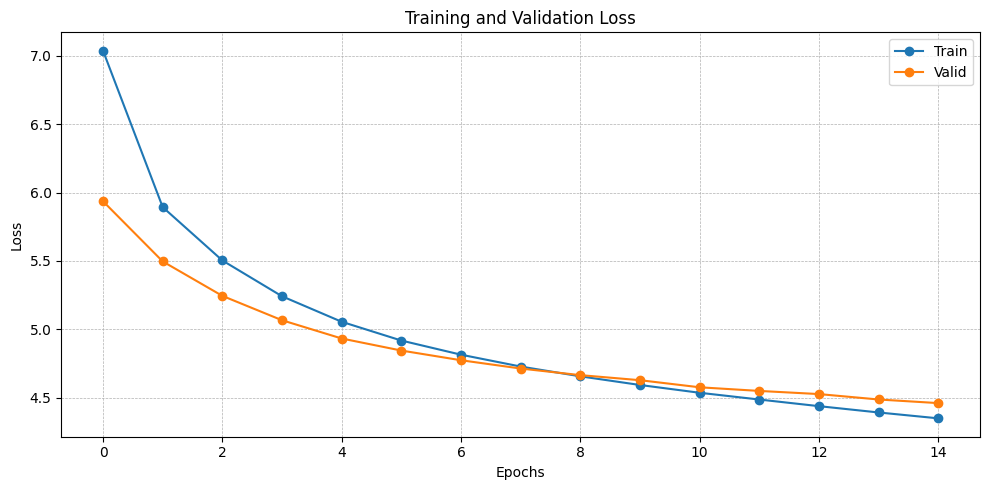

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


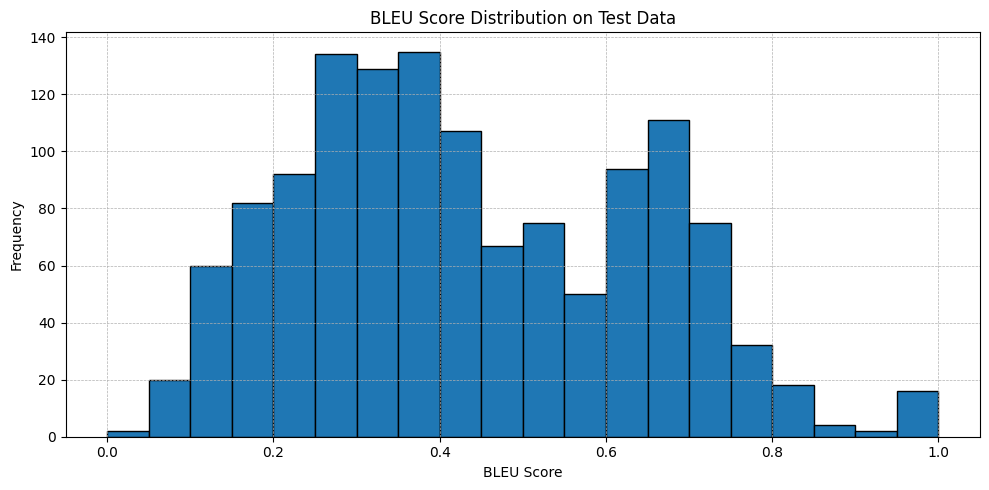

Average BLEU score on test data: 0.4350

Sample Translations:

Sample 1:
Source:
When I was in my 20s, I saw my very first psychotherapy client.
Target:
Quand j'avais la vingtaine, j'ai vu mes tout premiers clients comme psychothérapeute.
Predicted:
je suis allé , je suis allé , je suis allé à mon <UNK> . <EOS>
BLEU Score:
0.0000

Sample 2:
Source:
I was a Ph.D. student in clinical psychology at Berkeley.
Target:
J'étais étudiante en thèse en psychologie clinique à Berkeley.
Predicted:
je suis un <UNK> dans un <UNK> . <EOS>
BLEU Score:
0.0000

Sample 3:
Source:
She was a 26-year-old woman named Alex.
Target:
Elle, c'était une femme de 26 ans appelée Alex.
Predicted:
elle était un <UNK> <UNK> . <EOS>
BLEU Score:
0.0000

Sample 4:
Source:
Now Alex walked into her first session wearing jeans and a big slouchy top, and she dropped onto the couch in my office and kicked off her flats and told me she was there to talk about guy problems.
Target:
Lorsqu'Alex est entrée pour sa première séance

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import random
import os
import time
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import nltk
import matplotlib.pyplot as plt

# Download punkt tokenizer for NLTK
nltk.download('punkt')

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Adjusted Hyperparameters for Reduced Memory Usage
NUM_EPOCHS = 15
BATCH_SIZE = 128           # Reduced batch size
LEARNING_RATE = 0.0001
EMBED_SIZE = 256          # Reduced embedding size
NUM_HEADS = 4             # Reduced number of heads
NUM_ENCODER_LAYERS = 3    # Reduced number of encoder layers
NUM_DECODER_LAYERS = 3    # Reduced number of decoder layers
FORWARD_EXPANSION = 2     # Reduced forward expansion
DROPOUT = 0.1
PAD_IDX = 0

# Limit maximum sequence length
MAX_LEN = 60             # Reduced maximum sequence length

# Paths to data
DATA_PATH = '/kaggle/input/datafiles/data'  # Update this path to your data directory

# Vocabulary class
class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v: k for k, v in self.itos.items()}

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer(text):
        return nltk.word_tokenize(text.lower())

    def build_vocabulary(self, sentences):
        frequencies = Counter()
        idx = 4

        for sentence in sentences:
            tokens = self.tokenizer(sentence)
            frequencies.update(tokens)

        for word, freq in frequencies.items():
            if freq >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer(text)
        return [
            self.stoi.get(token, self.stoi["<UNK>"]) for token in tokenized_text
        ]

# Custom Dataset
class TranslationDataset(Dataset):
    def __init__(self, src_sentences, trg_sentences, src_vocab, trg_vocab, max_len):
        self.src_sentences = src_sentences
        self.trg_sentences = trg_sentences
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.src_sentences)

    def __getitem__(self, idx):
        src_sentence = self.src_sentences[idx]
        trg_sentence = self.trg_sentences[idx]

        src_tensor = [self.src_vocab.stoi["<SOS>"]] + self.src_vocab.numericalize(src_sentence) + [self.src_vocab.stoi["<EOS>"]]
        trg_tensor = [self.trg_vocab.stoi["<SOS>"]] + self.trg_vocab.numericalize(trg_sentence) + [self.trg_vocab.stoi["<EOS>"]]

        # Truncate sequences longer than max_len
        src_tensor = src_tensor[:self.max_len]
        trg_tensor = trg_tensor[:self.max_len]

        return torch.tensor(src_tensor), torch.tensor(trg_tensor)

# Collate function for DataLoader
def collate_fn(batch):
    src_batch, trg_batch = [], []
    for src_sample, trg_sample in batch:
        src_batch.append(src_sample)
        trg_batch.append(trg_sample)

    src_batch = nn.utils.rnn.pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = nn.utils.rnn.pad_sequence(trg_batch, padding_value=PAD_IDX)

    return src_batch, trg_batch

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, max_len):
        super(PositionalEncoding, self).__init__()
        self.embed_size = embed_size

        pe = torch.zeros(max_len, embed_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-math.log(10000.0) / embed_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        if embed_size % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(0)
        x = x * math.sqrt(self.embed_size)
        if seq_len > self.pe.size(0):
            # Truncate positional encoding to match sequence length
            pe = self.pe[:seq_len, :]
        else:
            pe = self.pe[:seq_len, :]
        x = x + pe
        return x

# Scaled Dot-Product Attention (Modified)
class ScaledDotProductAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(ScaledDotProductAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embed size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys   = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries= nn.Linear(self.head_dim, self.head_dim, bias=False)

        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[1]
        value_len, key_len, query_len = values.shape[0], keys.shape[0], query.shape[0]

        # Split embedding into self.heads pieces
        values  = values.view(value_len, N, self.heads, self.head_dim)
        keys    = keys.view(key_len, N, self.heads, self.head_dim)
        queries = query.view(query_len, N, self.heads, self.head_dim)

        values  = self.values(values)
        keys    = self.keys(keys)
        queries = self.queries(queries)

        # Compute energy
        energy = torch.einsum("qnhd, knhd -> nhqk", [queries, keys])

        if mask is not None:
            # Adjust mask shape to match energy
            # mask shape: (N, 1, 1, key_len)
            # Expand mask to (N, 1, query_len, key_len)
            mask = mask.expand(-1, -1, query_len, key_len)
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        # Attention weights
        attention = torch.softmax(energy / math.sqrt(self.head_dim), dim=3)

        # Compute context vector
        out = torch.einsum("nhql, lnhd -> qnhd", [attention, values]).reshape(
            query_len, N, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = ScaledDotProductAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

# Encoder
class Encoder(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length,
    ):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = PositionalEncoding(embed_size, max_length)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        # x shape: (seq_length, N)
        N = x.shape[1]

        embeddings = self.dropout(
            self.position_embedding(self.word_embedding(x))
        )

        out = embeddings
        for layer in self.layers:
            out = layer(out, out, out, mask)

        return out

# Decoder Block
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()
        self.attention = ScaledDotProductAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(
            embed_size, heads, dropout, forward_expansion
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, src_mask, trg_mask):
        attention = self.attention(x, x, x, trg_mask)
        query = self.dropout(self.norm(attention + x))
        out = self.transformer_block(value, key, query, src_mask)
        return out

# Decoder
class Decoder(nn.Module):
    def __init__(
        self,
        trg_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        device,
        max_length,
    ):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = PositionalEncoding(embed_size, max_length)

        self.layers = nn.ModuleList(
            [
                DecoderBlock(
                    embed_size,
                    heads,
                    forward_expansion,
                    dropout,
                    device,
                )
                for _ in range(num_layers)
            ]
        )

        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, trg_mask):
        # x shape: (trg_seq_len, N)
        N = x.shape[1]
        embeddings = self.dropout(
            self.position_embedding(self.word_embedding(x))
        )

        out = embeddings
        for layer in self.layers:
            out = layer(out, enc_out, enc_out, src_mask, trg_mask)

        out = self.fc_out(out)
        return out

# Transformer
class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        trg_pad_idx,
        embed_size=EMBED_SIZE,
        num_layers=NUM_ENCODER_LAYERS,
        forward_expansion=FORWARD_EXPANSION,
        heads=NUM_HEADS,
        dropout=DROPOUT,
        device=device,
        max_length=MAX_LEN,
    ):
        super(Transformer, self).__init__()

        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length,
        )

        self.decoder = Decoder(
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            device,
            max_length,
        )

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        # src shape: (src_seq_len, N)
        src_mask = (src != self.src_pad_idx).transpose(0, 1).unsqueeze(1).unsqueeze(2)
        # src_mask shape: (N, 1, 1, src_seq_len)
        return src_mask.to(self.device)

    def make_trg_mask(self, trg):
        # trg shape: (trg_seq_len, N)
        N = trg.shape[1]
        trg_len = trg.shape[0]

        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).bool().to(self.device)
        trg_mask = trg_mask.expand(N, 1, trg_len, trg_len)

        # Padding mask
        padding_mask = (trg != self.trg_pad_idx).transpose(0,1).unsqueeze(1).unsqueeze(3)
        trg_mask = trg_mask & padding_mask

        return trg_mask.to(self.device)

    def forward(self, src, trg):
        # src shape: (src_seq_len, N)
        # trg shape: (trg_seq_len, N)
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        enc_src = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_src, src_mask, trg_mask)
        return out

# Training function
def train_model(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for i, (src, trg) in enumerate(iterator):
        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        output = model(src, trg[:-1, :])

        output_dim = output.shape[-1]

        output = output.view(-1, output_dim)
        trg = trg[1:].reshape(-1)

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

# Evaluation function
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, (src, trg) in enumerate(iterator):
            src = src.to(device)
            trg = trg.to(device)

            output = model(src, trg[:-1, :])
            output_dim = output.shape[-1]

            output = output.view(-1, output_dim)
            trg = trg[1:].reshape(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

# Translate a sentence
def translate_sentence(model, src_sentence, src_vocab, trg_vocab, max_length):
    model.eval()

    src_tensor = src_sentence.to(device)

    src_mask = model.make_src_mask(src_tensor)

    enc_src = model.encoder(src_tensor, src_mask)

    trg_indices = [trg_vocab.stoi["<SOS>"]]

    for i in range(max_length):
        trg_tensor = torch.LongTensor(trg_indices).unsqueeze(1).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)

        output = model.decoder(trg_tensor, enc_src, src_mask, trg_mask)
        pred_token = output.argmax(2)[-1, :].item()

        trg_indices.append(pred_token)

        if pred_token == trg_vocab.stoi["<EOS>"]:
            break

    trg_tokens = [trg_vocab.itos[i] for i in trg_indices]

    return trg_tokens[1:]  # Exclude the initial <SOS>

# Main function
def main():
    # Load data
    with open(os.path.join(DATA_PATH, 'train.en'), 'r', encoding='utf-8') as f:
        train_en = f.readlines()

    with open(os.path.join(DATA_PATH, 'train.fr'), 'r', encoding='utf-8') as f:
        train_fr = f.readlines()

    with open(os.path.join(DATA_PATH, 'dev.en'), 'r', encoding='utf-8') as f:
        dev_en = f.readlines()

    with open(os.path.join(DATA_PATH, 'dev.fr'), 'r', encoding='utf-8') as f:
        dev_fr = f.readlines()

    with open(os.path.join(DATA_PATH, 'test.en'), 'r', encoding='utf-8') as f:
        test_en = f.readlines()

    with open(os.path.join(DATA_PATH, 'test.fr'), 'r', encoding='utf-8') as f:
        test_fr = f.readlines()

    # Strip newline characters
    train_en = [line.strip() for line in train_en]
    train_fr = [line.strip() for line in train_fr]
    dev_en = [line.strip() for line in dev_en]
    dev_fr = [line.strip() for line in dev_fr]
    test_en = [line.strip() for line in test_en]
    test_fr = [line.strip() for line in test_fr]

    # Build vocabularies
    SRC_FREQ_THRESHOLD = 2
    TRG_FREQ_THRESHOLD = 2

    src_vocab = Vocabulary(SRC_FREQ_THRESHOLD)
    src_vocab.build_vocabulary(train_en)

    trg_vocab = Vocabulary(TRG_FREQ_THRESHOLD)
    trg_vocab.build_vocabulary(train_fr)

    # Create datasets
    train_dataset = TranslationDataset(train_en, train_fr, src_vocab, trg_vocab, MAX_LEN)
    dev_dataset = TranslationDataset(dev_en, dev_fr, src_vocab, trg_vocab, MAX_LEN)
    test_dataset = TranslationDataset(test_en, test_fr, src_vocab, trg_vocab, MAX_LEN)

    # Data loaders
    train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    dev_iterator = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    test_iterator = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

    # Initialize model
    SRC_VOCAB_SIZE = len(src_vocab)
    TRG_VOCAB_SIZE = len(trg_vocab)

    model = Transformer(
        SRC_VOCAB_SIZE,
        TRG_VOCAB_SIZE,
        src_vocab.stoi["<PAD>"],
        trg_vocab.stoi["<PAD>"],
        embed_size=EMBED_SIZE,
        num_layers=NUM_ENCODER_LAYERS,
        forward_expansion=FORWARD_EXPANSION,
        heads=NUM_HEADS,
        dropout=DROPOUT,
        device=device,
        max_length=MAX_LEN,
    ).to(device)

    # Optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

    # Lists to keep track of losses
    train_losses = []
    valid_losses = []

    # Training loop
    for epoch in range(NUM_EPOCHS):
        start_time = time.time()

        train_loss = train_model(model, train_iterator, optimizer, criterion, clip=1)
        valid_loss = evaluate(model, dev_iterator, criterion)

        end_time = time.time()

        epoch_mins, epoch_secs = divmod(int(end_time - start_time), 60)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f}')

    # Plotting the training and validation loss
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Loss")
    plt.plot(train_losses, label="Train", marker='o')
    plt.plot(valid_losses, label="Valid", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.savefig('loss_plot.png', dpi=300)
    plt.show()

    # Save the model
    torch.save(model.state_dict(), 'transformer.pt')

    # Testing and BLEU score
    model.eval()
    test_bleu_scores = []

    with open('testbleu.txt', 'w', encoding='utf-8') as f:
        for idx in range(len(test_dataset)):
            src, trg = test_dataset[idx]
            src = src.unsqueeze(1).to(device)
            trg = trg.to(device)

            # **Truncate the source sequence to MAX_LEN to prevent positional encoding mismatch**
            src_numericalized = src_vocab.numericalize(test_en[idx])
            src_numericalized = src_numericalized[:MAX_LEN - 2]  # Reserve space for <SOS> and <EOS>
            src_tensor = torch.tensor([src_vocab.stoi["<SOS>"]] + src_numericalized + [src_vocab.stoi["<EOS>"]]).unsqueeze(1).to(device)

            predicted_trg = translate_sentence(model, src_tensor, src_vocab, trg_vocab, MAX_LEN)
            reference = [trg_vocab.itos[token] for token in trg.cpu().numpy()]
            reference = reference[1:-1]  # Exclude <SOS> and <EOS>
            predicted_trg = predicted_trg[:-1]  # Exclude <EOS>

            # Calculate BLEU score using standard weights
            score = sentence_bleu([reference], predicted_trg, weights=(0.25, 0.25, 0.25, 0.25))
            test_bleu_scores.append(score)
            f.write(' '.join(predicted_trg) + f' {score}\n')

    # Plot BLEU score distribution
    plt.figure(figsize=(10,5))
    plt.title("BLEU Score Distribution on Test Data")
    plt.hist(test_bleu_scores, bins=20, edgecolor='black')
    plt.xlabel("BLEU Score")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.savefig('bleu_distribution.png', dpi=300)
    plt.show()

    print(f'Average BLEU score on test data: {np.mean(test_bleu_scores):.4f}')

    # Sample translations
    num_samples = 5
    print("\nSample Translations:")
    for i in range(num_samples):
        src_sentence = test_en[i]
        trg_sentence = test_fr[i]

        # **Truncate the source sequence to MAX_LEN - 2 to prevent positional encoding mismatch**
        src_numericalized = src_vocab.numericalize(src_sentence)
        src_numericalized = src_numericalized[:MAX_LEN - 2]  # Reserve space for <SOS> and <EOS>
        src_tensor = torch.tensor([src_vocab.stoi["<SOS>"]] + src_numericalized + [src_vocab.stoi["<EOS>"]]).unsqueeze(1).to(device)

        predicted_trg = translate_sentence(model, src_tensor, src_vocab, trg_vocab, MAX_LEN)
        reference = trg_sentence.split()
        reference = reference[:MAX_LEN - 2]  # Truncate reference if necessary

        # Calculate BLEU score for the sample using standard weights
        sample_bleu = sentence_bleu([reference], predicted_trg, weights=(0.25, 0.25, 0.25, 0.25))

        # Print in the requested structured format
        print(f"\nSample {i+1}:")
        print("Source:")
        print(src_sentence)
        print("Target:")
        print(trg_sentence)
        print("Predicted:")
        print(' '.join(predicted_trg))
        print("BLEU Score:")
        print(f"{sample_bleu:.4f}")

if __name__ == '__main__':
    main()
